In [1]:
#General imports.
import ROOT as r
import math
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
r.gStyle.SetOptStat(0)
r.gStyle.SetOptFit(1111)
import matplotlib.pyplot as plt
import csv
import pandas

import seaborn as sns
sns.set(style="ticks", color_codes=True)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
import os
import scipy

import uproot # https://indico.cern.ch/event/686641/contributions/2894906/attachments/1606247/2548596/pivarski-uproot.pdf
from awkward import JaggedArray
from root_pandas import read_root # https://github.com/scikit-hep/root_pandas

import warnings
warnings.filterwarnings('once')

%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'

Welcome to JupyROOT 6.12/06


In [2]:
#f = r.TFile("./data/energy_time_60hr_most.root")
f = r.TFile("./data/Energy_v_Time_KS_60h.root")
f.ls()

TFile**		./data/Energy_v_Time_KS_60h.root	
 TFile*		./data/Energy_v_Time_KS_60h.root	
  KEY: TCanvas	c1;1	c1


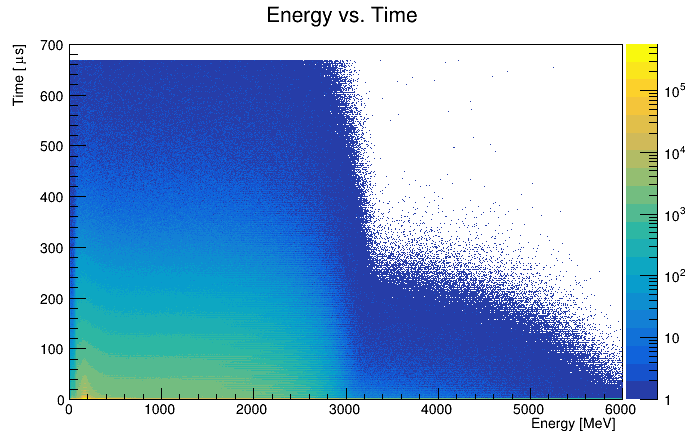

In [3]:
c1 = f.Get("c1")
c1.Draw()

In [4]:
c1.GetListOfPrimitives().Print()

Collection name='TList', class='TList', size=3
 TFrame  X1=0.000000 Y1=0.000000 X2=6000.000000 Y2=700.000000 FillStyle=1001
 TH1.Print Name  = h, Entries= -2147483648, Total sum= 8.07188e+09
 TPaveText  X1=1933.620674 Y1=729.735179 X2=4066.379326 Y2=783.125011
 Collection name='TList', class='TList', size=1
  Text  X=0.000000 Y=0.000000 Text=Energy vs. Time Font=0 Size=0.000000 Color=0 Align=0


In [5]:
evt =c1.GetPrimitive("h").Clone("evt")
evt.SetDirectory(0)

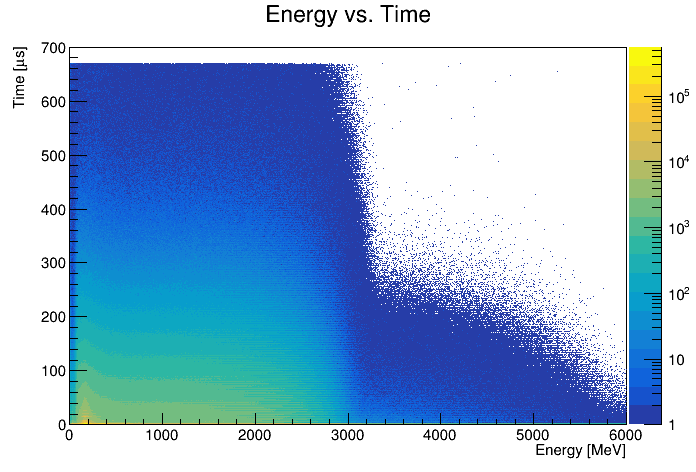

In [6]:
c2 = r.TCanvas()
evt.Draw("COLZ")
c2.SetLogz()
c2.Draw()

In [7]:
print(evt.GetNbinsX(),evt.GetNbinsY())
print("x:",evt.GetXaxis().GetXmin(), evt.GetXaxis().GetXmax())
print("y:",evt.GetYaxis().GetXmin(), evt.GetYaxis().GetXmax())

12000 4700
x: 0.0 6000.0
y: 0.0 700.0


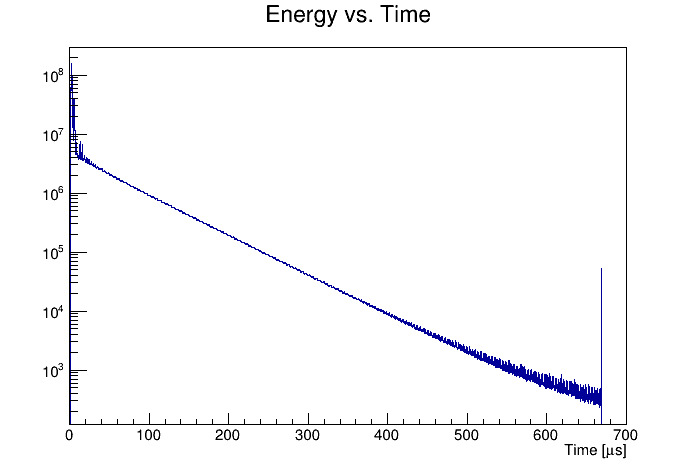

In [8]:
c2 = r.TCanvas()
evt.GetXaxis().SetRangeUser(0,700)
evt_time = evt.ProjectionY().Clone()
evt_time.Draw("COLZ")
c2.SetLogy()
c2.Draw()

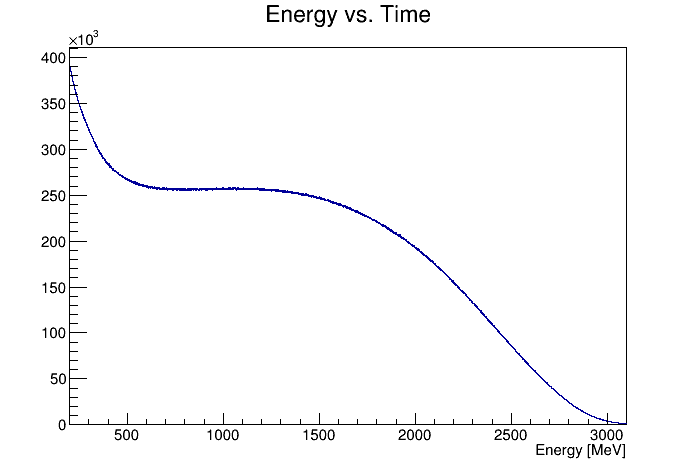

In [9]:
c2 = r.TCanvas()
e1 = 200 #200 and 3100 produced a stable result in the visualizer
e2 = 3100
t1 = 100
t2 = 400

t1global = t1
t2global = t2 

evt.GetXaxis().SetRangeUser(e1,e2)
evt.GetYaxis().SetRangeUser(30,600)

cuti = r.TCutG("cuti")
cuti.SetPoint(0,e1,t1)
cuti.SetPoint(1,e2,t1)
cuti.SetPoint(2,e2,t2)
cuti.SetPoint(3,e1,t2)
cuti.SetPoint(4,e1,t1)

h = evt.ProjectionX("h",0,-1,"[cuti]").Clone()
#h.Scale(1/(h.GetEntries()))
h.Draw()
c2.Draw()

In [10]:
timeBinWidth = evt_time.GetBinWidth(100)
timeBinCenters = []
for i in range(evt_time.GetNbinsX()):
    binCenter = evt_time.GetBinCenter(i)
    if(binCenter > t1 and binCenter < t2):
        timeBinCenters.append(binCenter)

In [11]:
timeBinWidth

0.14893617021276595

In [12]:
timeBinCenters[:10]

[100.01063829787235,
 100.15957446808511,
 100.30851063829788,
 100.45744680851064,
 100.6063829787234,
 100.75531914893617,
 100.90425531914893,
 101.05319148936171,
 101.20212765957447,
 101.35106382978724]

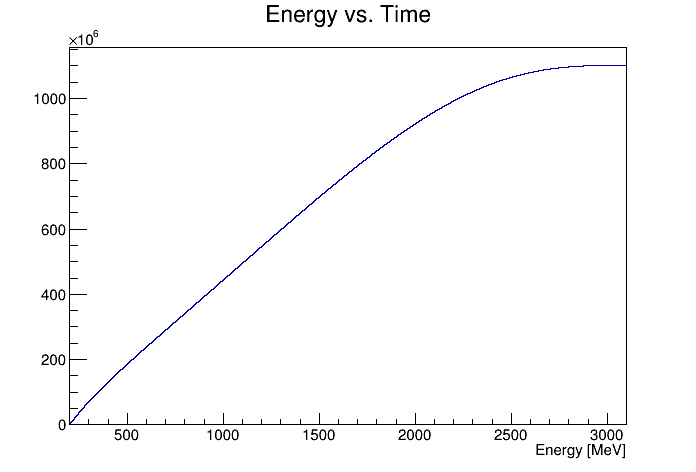

In [13]:
hcum = h.GetCumulative()
c2 = r.TCanvas()
hcum.Draw()
c2.Draw()

In [14]:
hscaled = h.Clone("hscaled")
hscaled.Scale(1/(hscaled.GetEntries()))

In [15]:
ndivs = len(timeBinCenters)
numberOfBins = 1
print(ndivs)
timeSlices = []
timeSlicesCum = []
times = []
for div in range(ndivs):
    t1 = timeBinCenters[div] - timeBinWidth*numberOfBins
    t2 = timeBinCenters[div] + timeBinWidth*numberOfBins
    evt.GetYaxis().SetRangeUser(t1,t2)
    
    cuti = r.TCutG("cuti")
    cuti.SetPoint(0,e1,t1)
    cuti.SetPoint(1,e2,t1)
    cuti.SetPoint(2,e2,t2)
    cuti.SetPoint(3,e1,t2)
    cuti.SetPoint(4,e1,t1)

    htemp = evt.ProjectionX("htemp",0,-1,"[cuti]").Clone()
    htemp.SetTitle("EvT Projection from Time Slice "+str(t1).zfill(3)+" - "+str(t2).zfill(3))
    #htemp.Scale(1/(htemp.GetEntries()))
    
    '''
    hprint = htemp.Clone("hprint")
    hprint.Scale(1/(hprint.GetEntries()))
    c = r.TCanvas("c","c",1000,1000)
    hscaled.Draw("HIST")
    hprint.SetLineColor(2)
    hprint.Draw("HIST SAME")
    hscaled.GetXaxis().SetRangeUser(0.0001,0.01)
    c.SetLogy()
    c.Draw()
    c.Print("./images/evt_"+str(div).zfill(5)+".png")
    '''
    
    timeSlices.append(htemp.Clone("h"+str(div+1)))
    timeSlicesCum.append(htemp.GetCumulative().Clone("hcum"+str(div+1)))
    times.append(t1)

2015


In [16]:
hscaledcum = hcum.Clone("hscaledcum")
#hscaled.Scale(1/(hscaled.GetEntries()))

for div in range(500):#ndivs):
    hprint = timeSlicesCum[div].Clone("hprint")
    #hprint.Scale(1/(hprint.GetEntries()))
    c = r.TCanvas("c","c",1000,1000)
    hscaledcum.Draw("HIST")
    hprint.SetLineColor(2)
    hprint.Draw("HIST SAME")
    #hscaled.GetXaxis().SetRangeUser(0.0001,0.01)
    c.SetLogy()
    c.Draw()
    #c.Print("./images/evt_cum_"+str(div).zfill(5)+".png")

In [17]:
ks = []
for i, hslice in enumerate(timeSlicesCum):
    ksi = hcum.KolmogorovTest(hslice,"MX") #X = pseudo experiment post processor
    ks.append(ksi)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



print(ks)

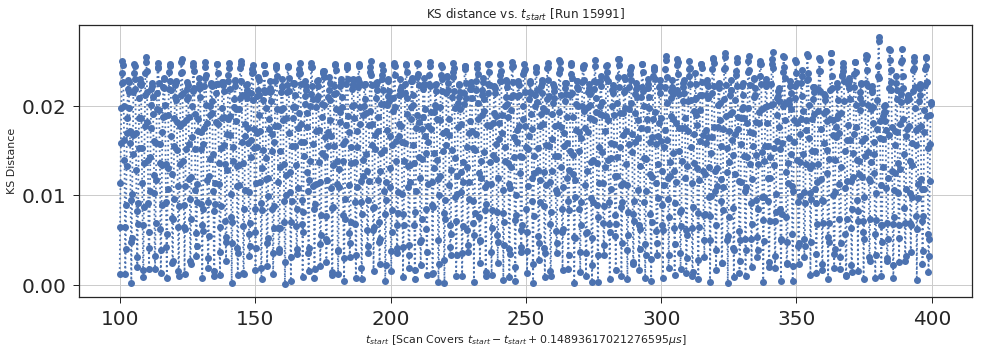

In [18]:
fig, ax = plt.subplots(figsize=(16,5))
plt.plot(times,ks,':o')
plt.title(r"KS distance vs. $t_{start}$ [Run 15991]")
plt.xlabel(r"$t_{start}$ [Scan Covers $t_{start} - t_{start} + "+str(timeBinWidth)+r" \mu s$]")
plt.ylabel("KS Distance")
plt.grid()
plt.show()

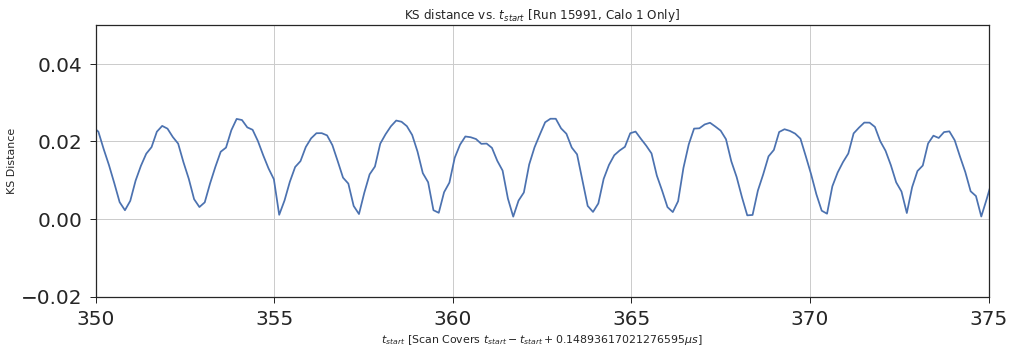

In [19]:
fig, ax = plt.subplots(figsize=(16,5))
plt.plot(times,ks,'-')
plt.title(r"KS distance vs. $t_{start}$ [Run 15991, Calo 1 Only]")
plt.xlabel(r"$t_{start}$ [Scan Covers $t_{start} - t_{start} + "+str(timeBinWidth)+r" \mu s$]")
plt.ylabel("KS Distance")
plt.xlim(350,375)
plt.ylim(-0.02,0.05)
plt.grid()
plt.show()

In [20]:
hspec = evt_time.Clone()
hspec.SetTitle("KS Distance vs. Time; Time [#mus]; d_{KS}")
hspec.Reset()
#hspec = r.TH1D("hspec","hspec",4700,0,700)
for i, ksi in enumerate(zip(times,ks)):
    binnum = hspec.FindBin(ksi[0])
    hspec.SetBinContent(binnum,ksi[1])

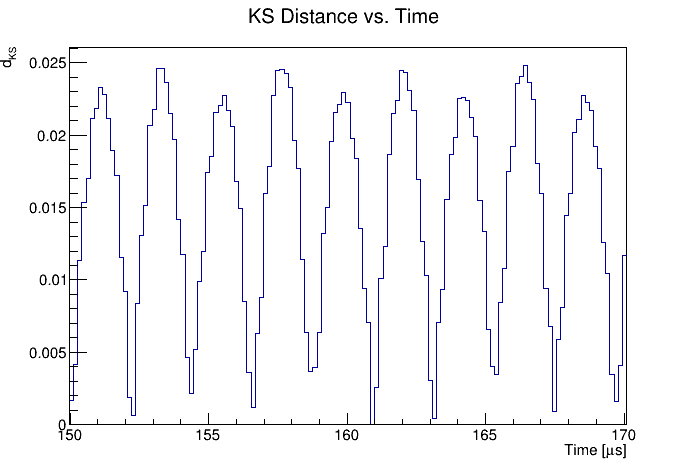

In [21]:
c = r.TCanvas()
hspec.Draw()
hspec.GetXaxis().SetRangeUser(150,170)
c.Draw()

In [22]:
hspec_orig = hspec.Clone() #keep this one unchanged so we can keep getting fit histograms from it

In [23]:
hspec2 = hspec.Clone()
hspec3 = hspec.Clone()
hspec4 = hspec.Clone()

In [24]:
getBlinded = Blinders(FitType.Omega_a, 'This is my fight song. Blinding my plot song.')
def peak_fit_sine(x, p):
    R = p[1]
    omega = getBlinded.paramToFreq(R)
    return p[0]*r.TMath.Abs(r.TMath.Sin(omega*x[0] + p[2])) + p[3]

def peak_fit_sine_2(x, p):
    R = p[1]
    omega = getBlinded.paramToFreq(R)
    return p[0]*r.TMath.Abs(r.TMath.Sin(omega*x[0] + p[2])) + p[3] +( p[4] + p[5]*(x[0]*x[0] - p[6]) )*r.TMath.Sin(omega*x[0] + p[2])

def peak_fit_sine_3(x, p):
    R = p[1]
    omega = getBlinded.paramToFreq(R)
    return p[0]*r.TMath.Abs(r.TMath.Sin(omega*x[0] + p[2])) + p[3] +( p[4] )*r.TMath.Sin(omega*x[0] + p[2])

func1 = r.TF1("simplesine", peak_fit_sine, 100,400,4)
func1.SetParNames('A','R','#phi','+ C')
func1.SetParameters(0.03,0,0,0.002)
func1.SetParLimits(0,0.02,100)
func1.SetLineColor(2)
func1.SetNpx(1000)

func2 = r.TF1("complexsine", peak_fit_sine_2, 100,400,7)
func2.SetParNames('A_{1}','R','#phi_{1}','+ C', 'A_{2}', 'A_{2, t-quad}', 'A_{2,t - center}', 'A_{2,t-linear}')
func2.SetParameters(0.03,0,0,0.002,0.002,0.000001,100,0.000000000001)
func2.SetParLimits(0,0.02,100)
func2.SetLineColor(4)
func2.SetNpx(1000)

func3 = r.TF1("modsine", peak_fit_sine_3, 100,400,5)
func3.SetParNames('A_{1}','R','#phi_{1}','+ C', 'A_{2}', 'A_{2, t-quad}', 'A_{2,t - center}', 'A_{2,t-linear}')
func3.SetParameters(0.03,0,0,0.002,0.002,0.000001,100,0.000000000001)
func3.SetParLimits(0,0.02,100)
func3.SetLineColor(3)
func3.SetNpx(1000)

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


 FCN=0.0231094 FROM MINOS     STATUS=PROBLEMS      317 CALLS        4173 TOTAL
                     EDM=4.18452e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  A            2.42421e-02   2.45511e-02   2.00297e-04  -8.29608e-02
   2  R           -1.75947e+01   3.79884e+04   1.47439e+01   7.11281e-06
   3  #phi         7.09182e+00   8.75932e+00  -1.13831e-03   1.04459e-01
   4  + C         -5.03979e-04   6.90669e-03   6.90669e-03   4.40393e-01


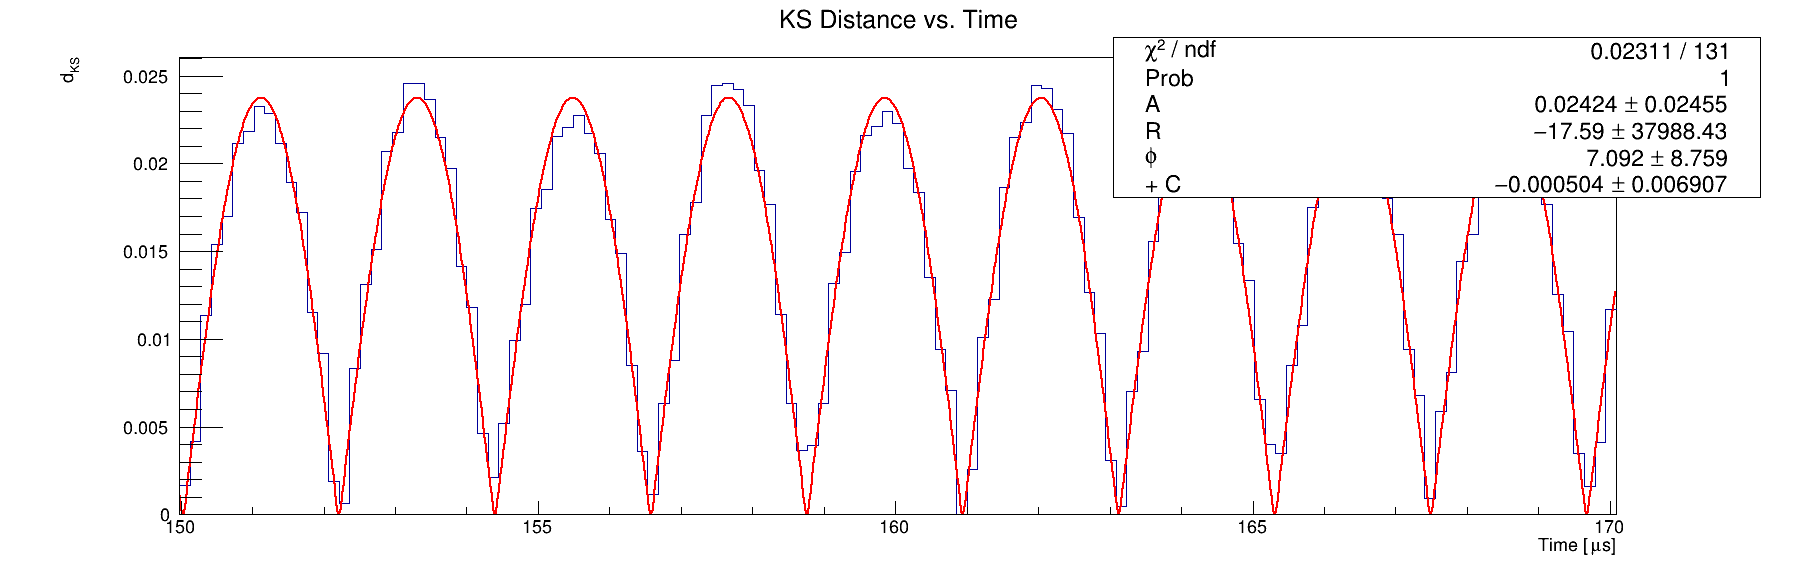

In [25]:
c = r.TCanvas("c","c",1800,600)
hspec.Draw()

hspec2.GetXaxis().SetRangeUser(50,550)
hspec.Fit("simplesine","REMB")
hspec2.GetXaxis().SetRangeUser(50,70)

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


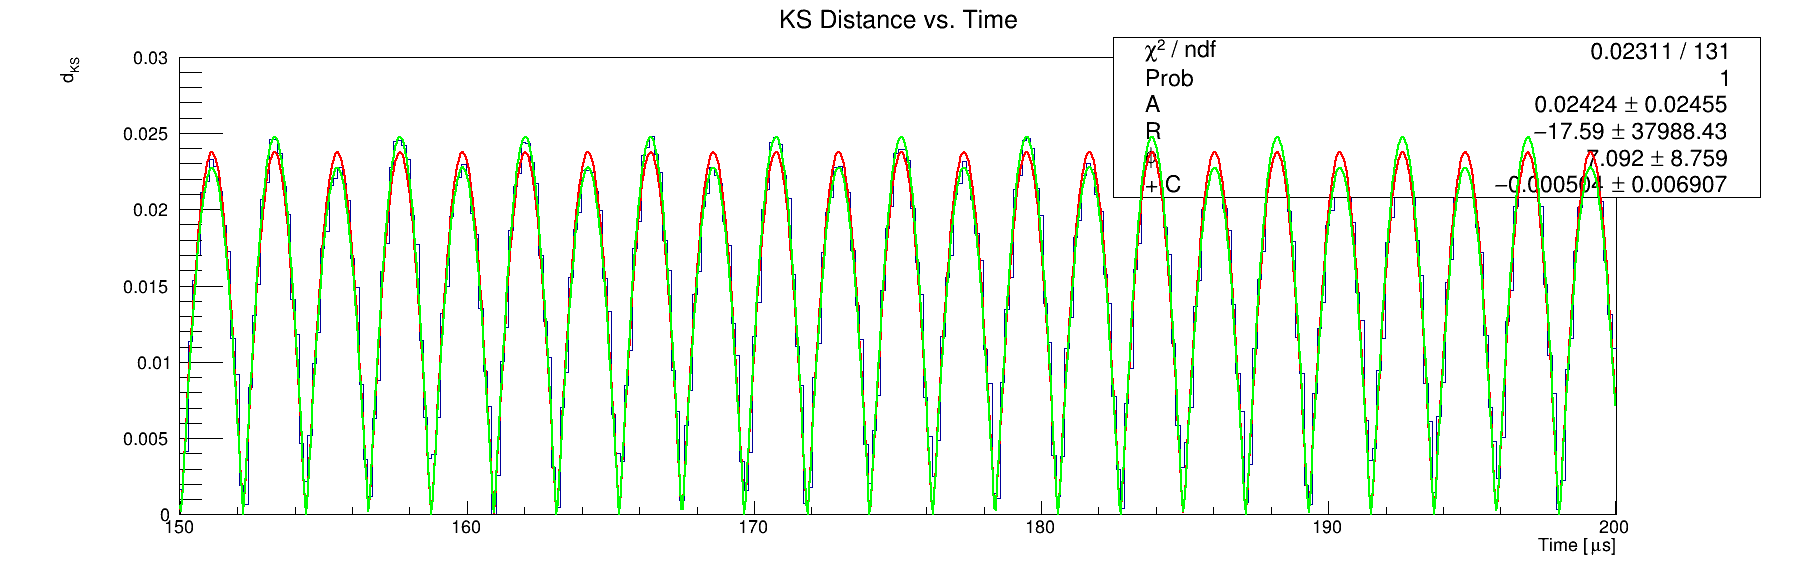

In [26]:
c = r.TCanvas("c","c",1800,600)
hspec.Draw()
hspec.GetYaxis().SetRangeUser(0,0.03)
hspec.GetXaxis().SetRangeUser(150,200)
for i in range(4):
    func3.SetParameter(i, func1.GetParameter(i))  
func3.SetParameter(4,0.001)
func3.SetParameter(5,0)
func1.Draw("SAME")
func3.Draw("SAME")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


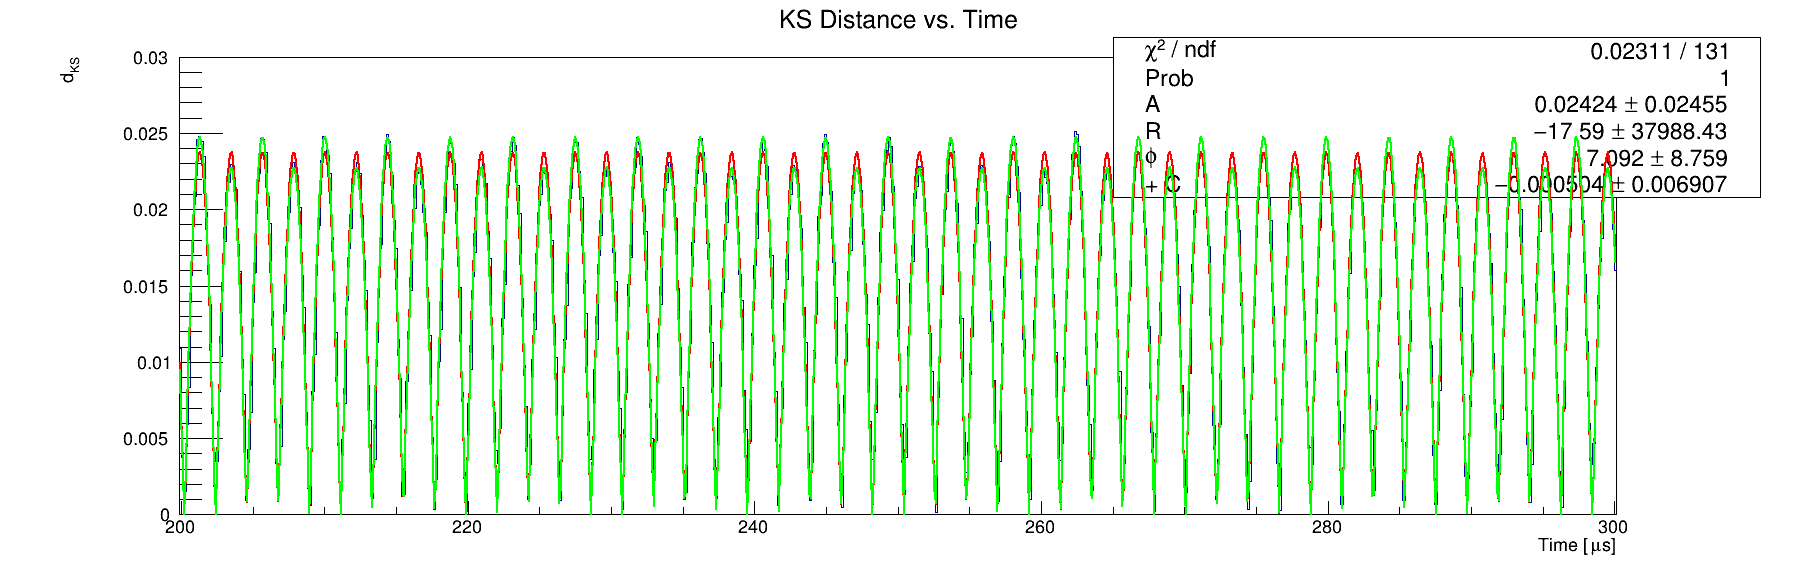

In [27]:
c = r.TCanvas("c","c",1800,600)
hspec.Draw()
hspec.GetXaxis().SetRangeUser(200,300)
func1.Draw("SAME")
func3.Draw("SAME")
c.Draw()

func2.FixParameter(2, func1.GetParameter(2))

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


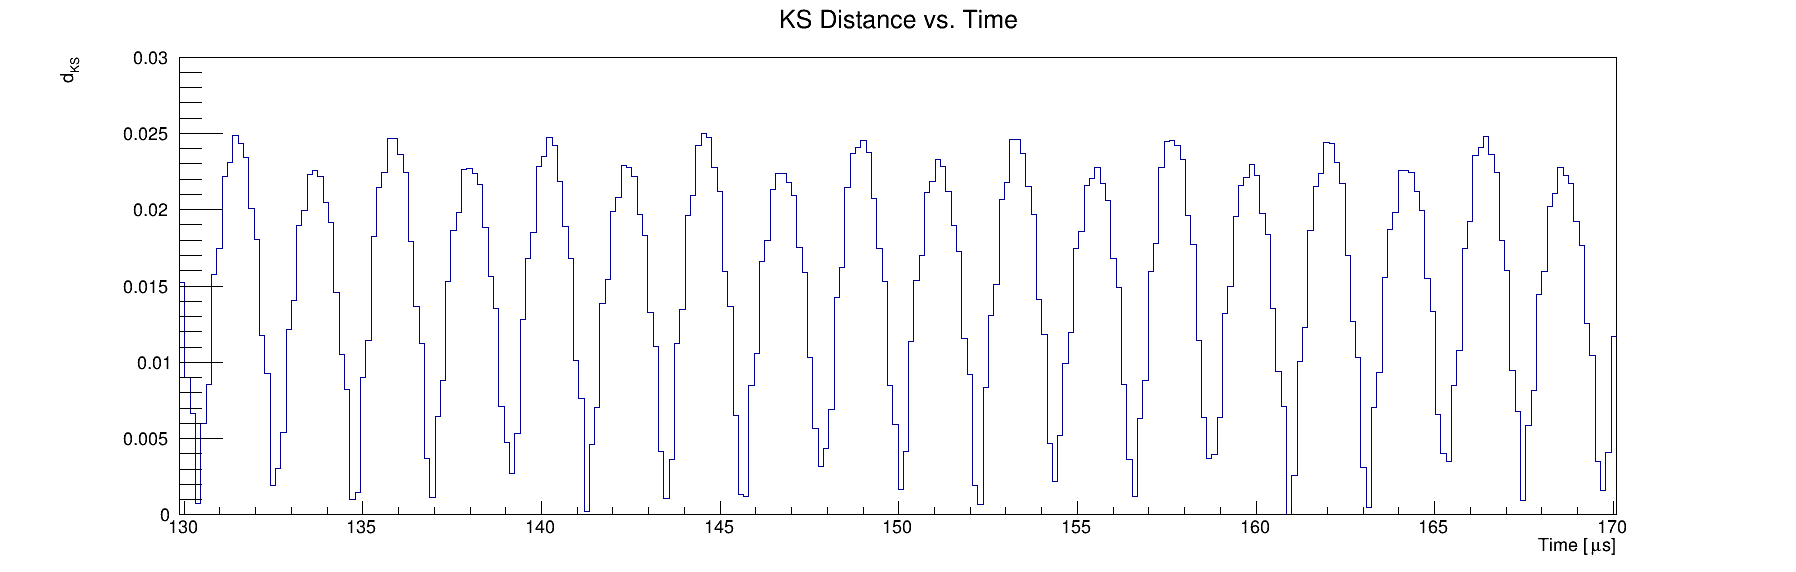

In [28]:
c = r.TCanvas("c","c",1800,600)
hspec2.Draw()
hspec2.GetYaxis().SetRangeUser(0,0.03)
hspec2.GetXaxis().SetRangeUser(130,170)
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


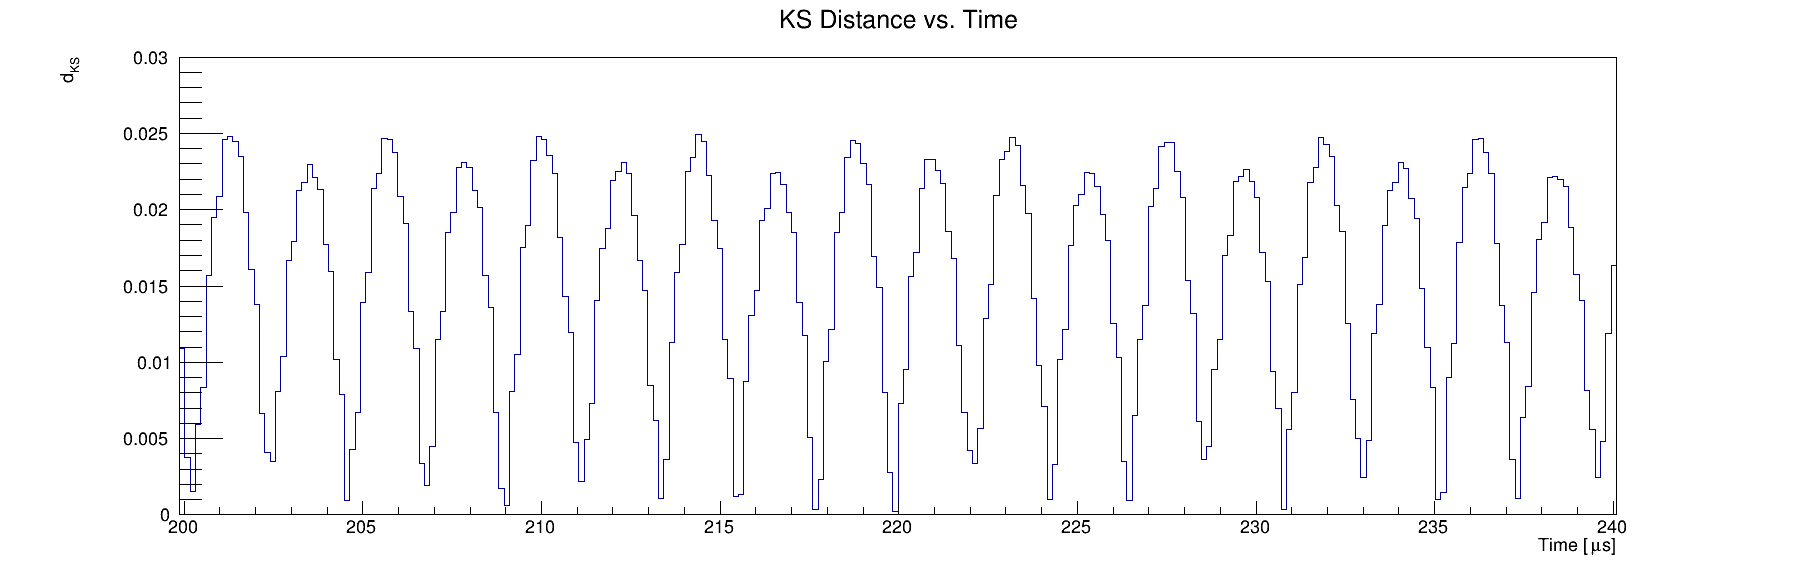

In [29]:
c = r.TCanvas("c","c",1800,600)
hspec2.Draw()
hspec2.GetYaxis().SetRangeUser(0,0.03)
hspec2.GetXaxis().SetRangeUser(200,240)
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


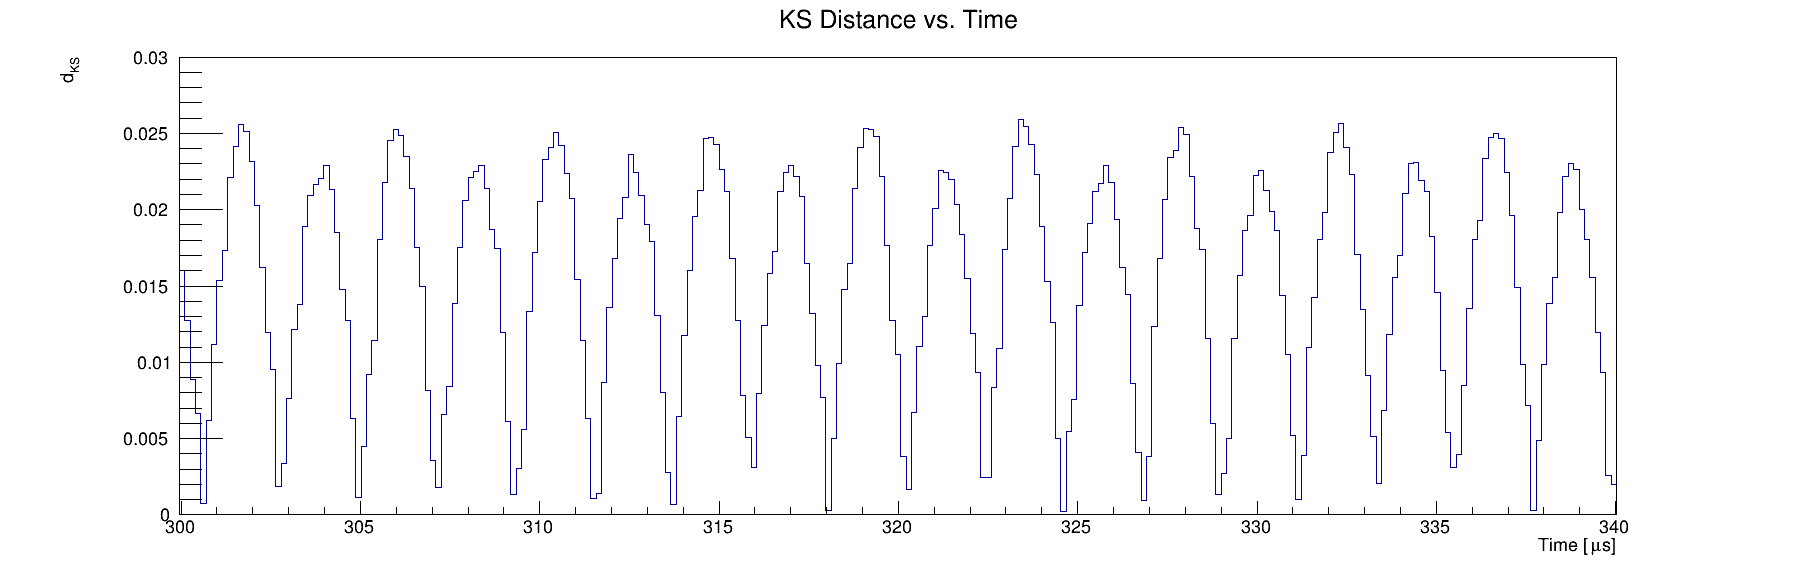

In [30]:
c = r.TCanvas("c","c",1800,600)
hspec2.Draw()
hspec2.GetYaxis().SetRangeUser(0,0.03)
hspec2.GetXaxis().SetRangeUser(300,340)
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


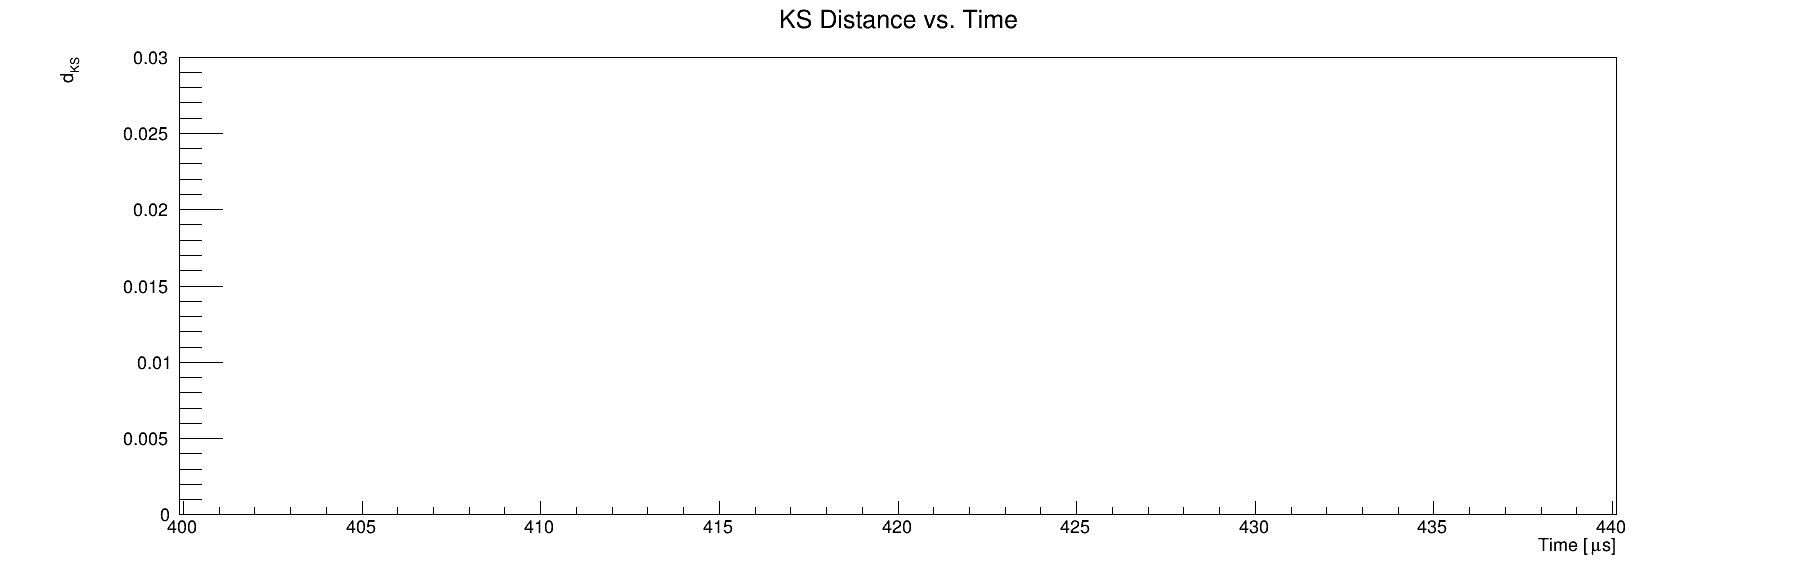

In [31]:
c = r.TCanvas("c","c",1800,600)
hspec2.Draw()
hspec2.GetYaxis().SetRangeUser(0,0.03)
hspec2.GetXaxis().SetRangeUser(400,440)
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


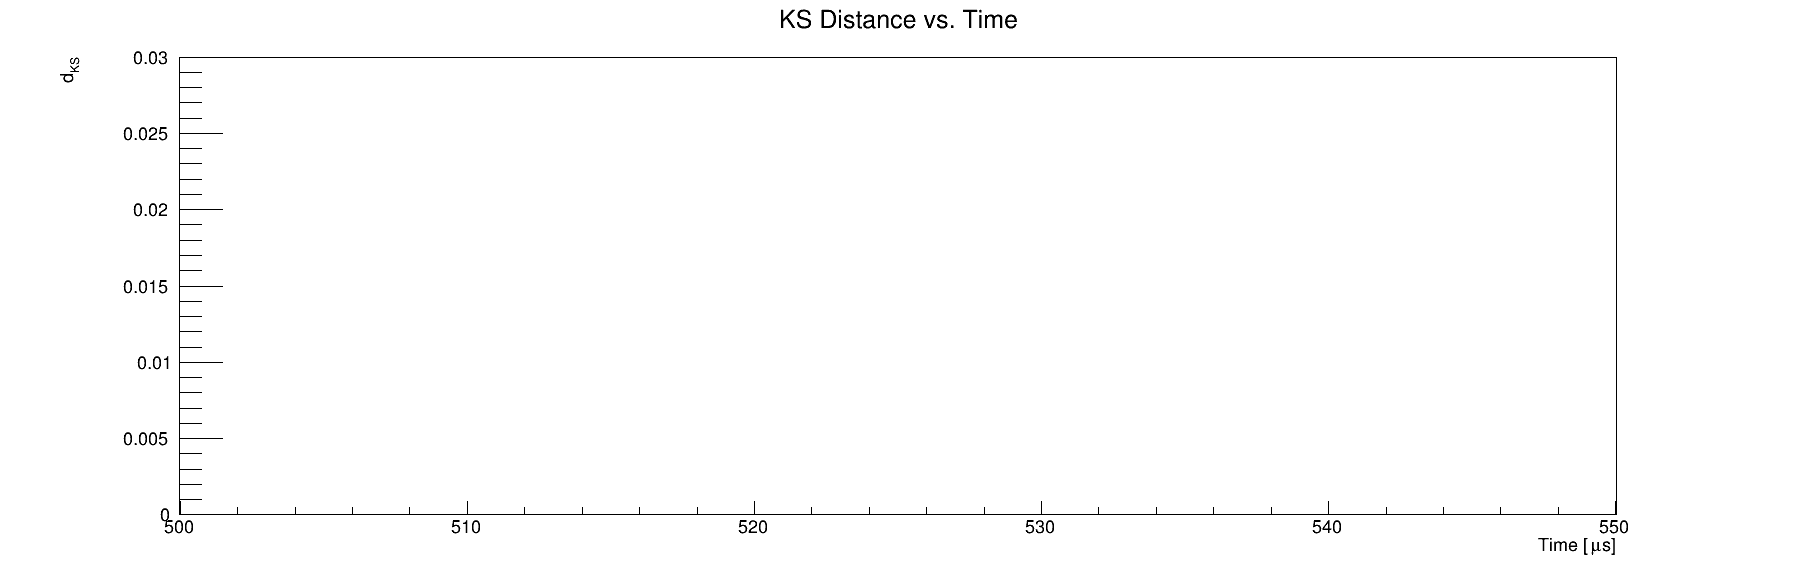

In [32]:
c = r.TCanvas("c","c",1800,600)
hspec2.Draw()
hspec2.GetYaxis().SetRangeUser(0,0.03)
hspec2.GetXaxis().SetRangeUser(500,550)
c.Draw()

Starting fit: 1
Starting fit: 2
 FCN=0.379115 FROM MINOS     STATUS=SUCCESSFUL     37 CALLS        1104 TOTAL
                     EDM=5.47259e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  A_{1}        2.40591e-02   5.67222e-03  -3.90859e-06   5.26370e-04
   2  R            3.17412e+01   6.48440e+02  -1.92462e-03  -1.53540e-08
   3  #phi_{1}     7.07879e+00   2.39921e-01   5.87985e-06  -1.07768e-04
   4  + C         -3.39909e-04   2.29517e-03   5.32112e-07   4.19234e-03
   5  A_{2}        8.71206e-04   4.28198e-03   4.28198e-03  -1.04503e-02
 FCN=0.379115 FROM MINOS     STATUS=SUCCESSFUL     36 CALLS        1079 TOTAL
                     EDM=2.47382e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


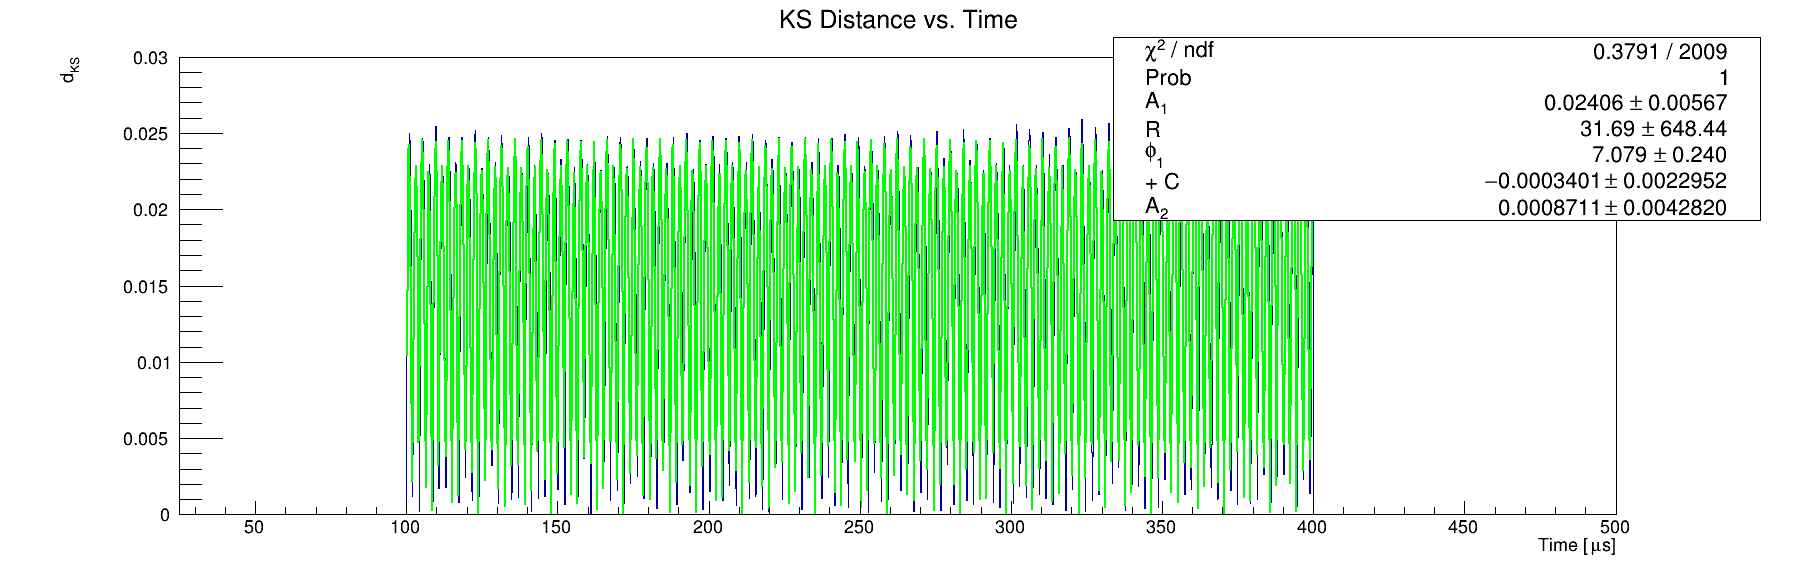

In [33]:
c = r.TCanvas("c","c",1800,600)
hspec2.Draw()
hspec2.GetXaxis().SetRangeUser(25,500)
for i in range(2):
    print("Starting fit:", i+1)
    hspec2.Fit("modsine","REMB")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


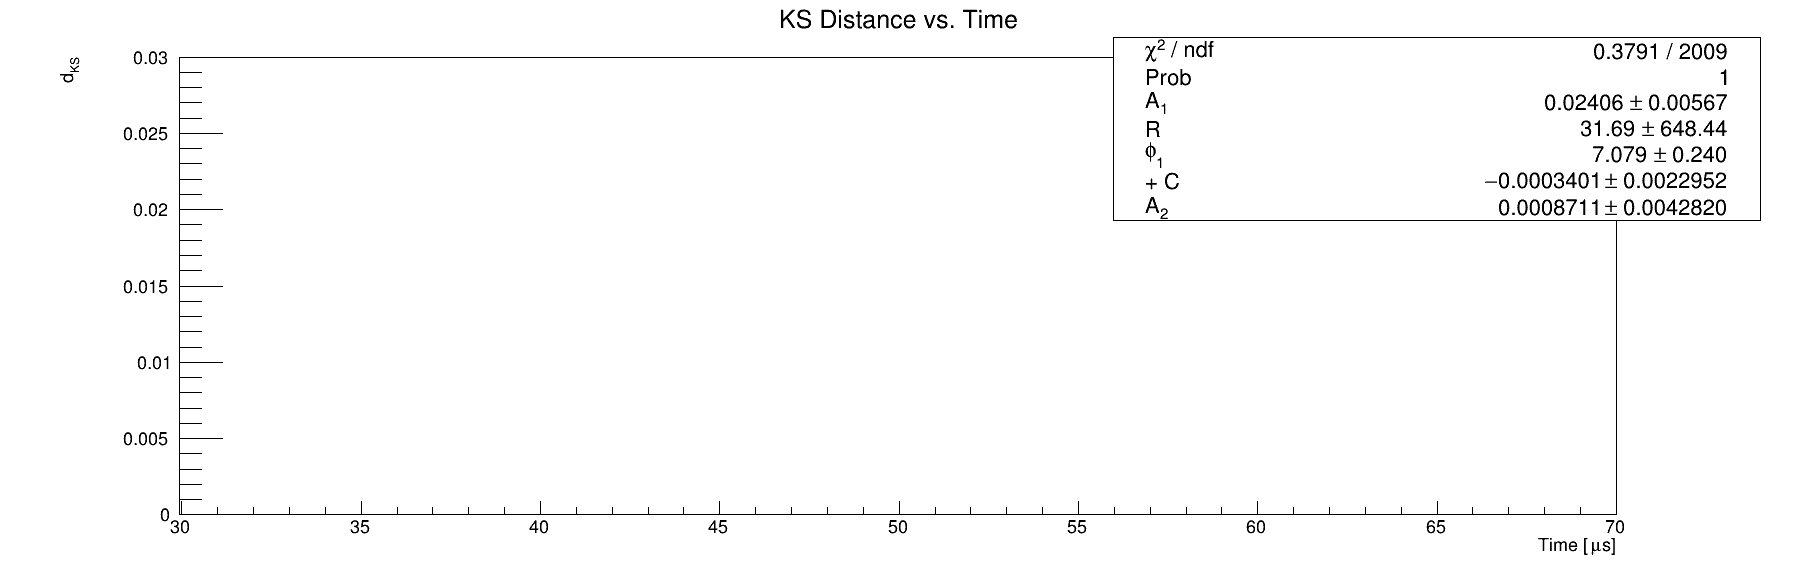

In [34]:
c = r.TCanvas("c","c",1800,600)
hspec2.Draw()
hspec2.GetYaxis().SetRangeUser(0,0.03)
hspec2.GetXaxis().SetRangeUser(30,70)
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


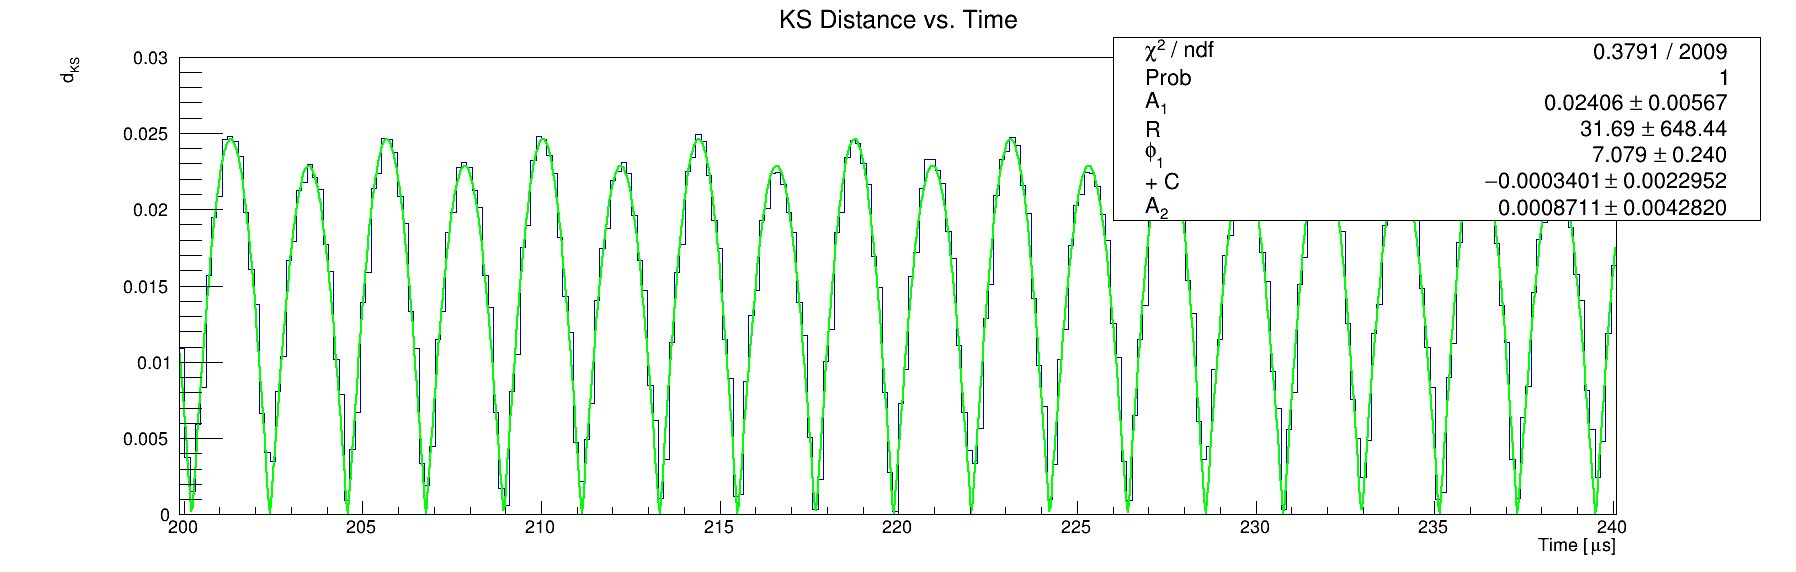

In [35]:
c = r.TCanvas("c","c",1800,600)
hspec2.Draw()
hspec2.GetYaxis().SetRangeUser(0,0.03)
hspec2.GetXaxis().SetRangeUser(200,240)
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


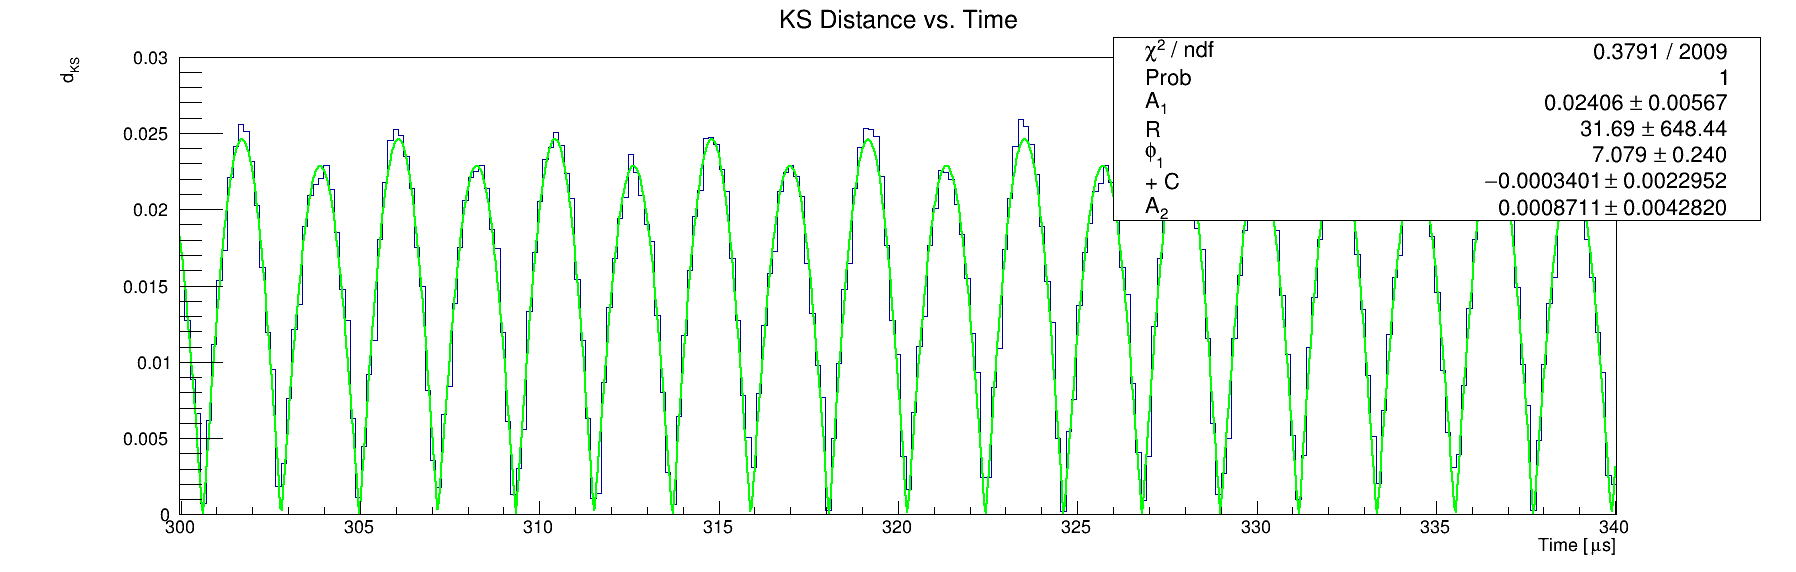

In [36]:
c = r.TCanvas("c","c",1800,600)
hspec2.Draw()
hspec2.GetYaxis().SetRangeUser(0,0.03)
hspec2.GetXaxis().SetRangeUser(300,340)
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


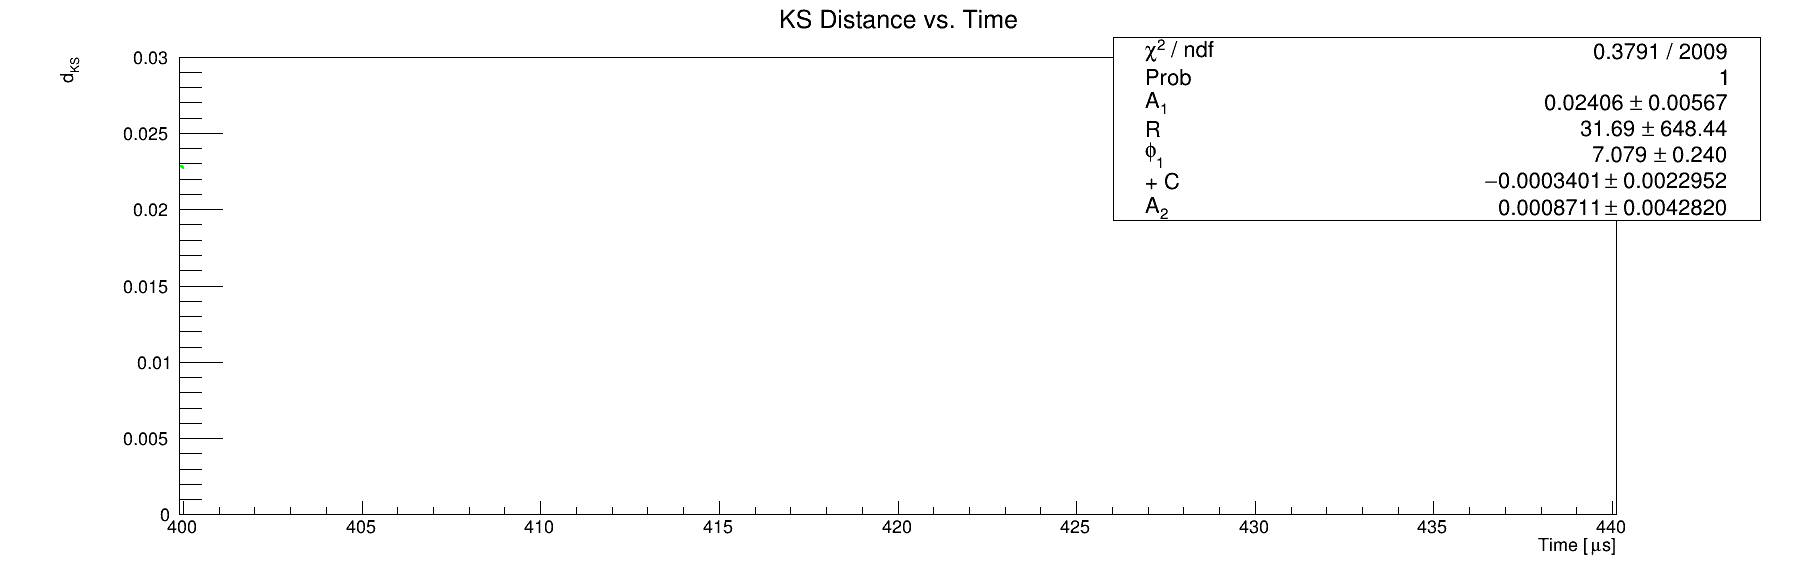

In [37]:
c = r.TCanvas("c","c",1800,600)
hspec2.Draw()
hspec2.GetYaxis().SetRangeUser(0,0.03)
hspec2.GetXaxis().SetRangeUser(400,440)
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


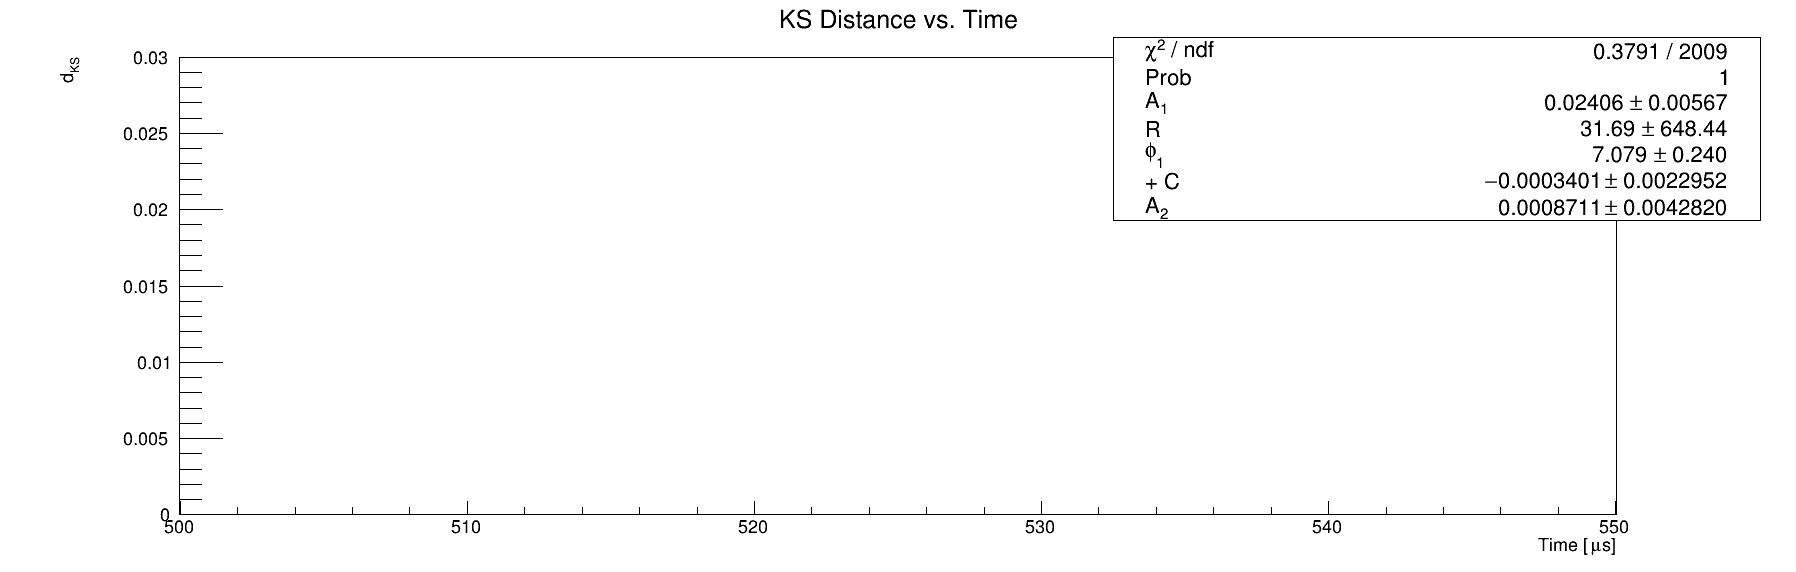

In [38]:
c = r.TCanvas("c","c",1800,600)
hspec2.Draw()
hspec2.GetYaxis().SetRangeUser(0,0.03)
hspec2.GetXaxis().SetRangeUser(500,550)
c.Draw()

Creating new Ratio Plot


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


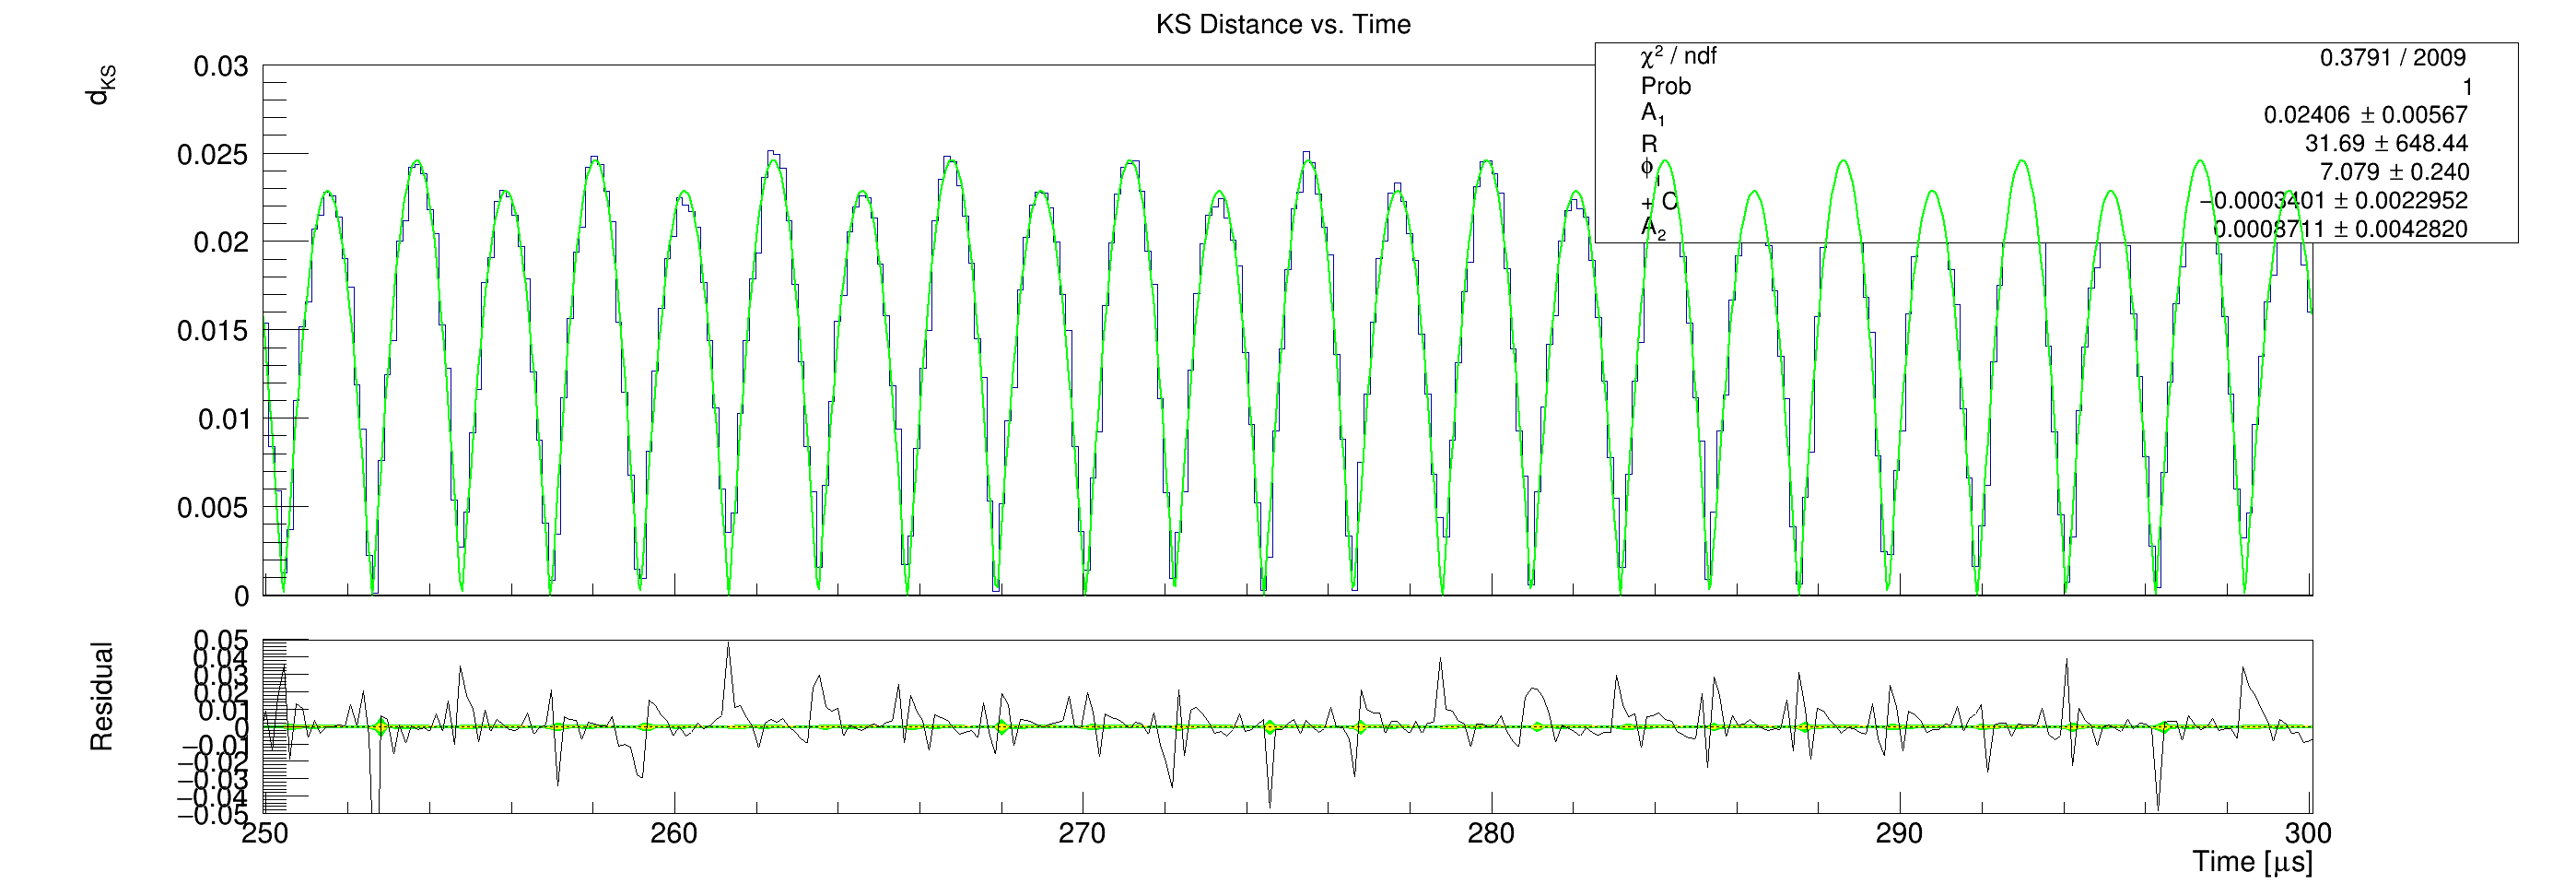

In [39]:
#The class calculates the  difference between the histogram and the fit function at each point 
#    and divides it by the uncertainty.
c3 = r.TCanvas("c","c",2800,1000)
hspec2.Draw()
hspec2.GetXaxis().SetRangeUser(250,300)

c3.Draw()

try:
    rp1.Delete()
except:
    print("Creating new Ratio Plot")

rp1 = r.TRatioPlot(hspec2)
rp1.Draw()
rp1.GetLowerRefYaxis().SetTitle("Residual")
rp1.GetLowerRefYaxis().SetRangeUser(-0.05,0.05)


c3.Update()
c3.Draw()

---

In [40]:
hspec_resid2 = hspec2.Clone()
hspec_resid2.Reset()
hspec_resid2.SetTitle("Residuals of KS vs. Time Fit")

residVec = []
nBins = hspec2.GetSize() - 2
for i in range(nBins):
    binCenterX = hspec2.GetXaxis().GetBinCenter(i)
    if (binCenterX > t1global and binCenterX < t2global):
        residVec.append( (binCenterX, hspec2.GetBinContent(i) - func3.Eval(binCenterX) ) )
        hspec_resid2.SetBinContent(i, hspec2.GetBinContent(i) - func3.Eval(binCenterX))
    else:
        hspec_resid2.SetBinContent(i, 0)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


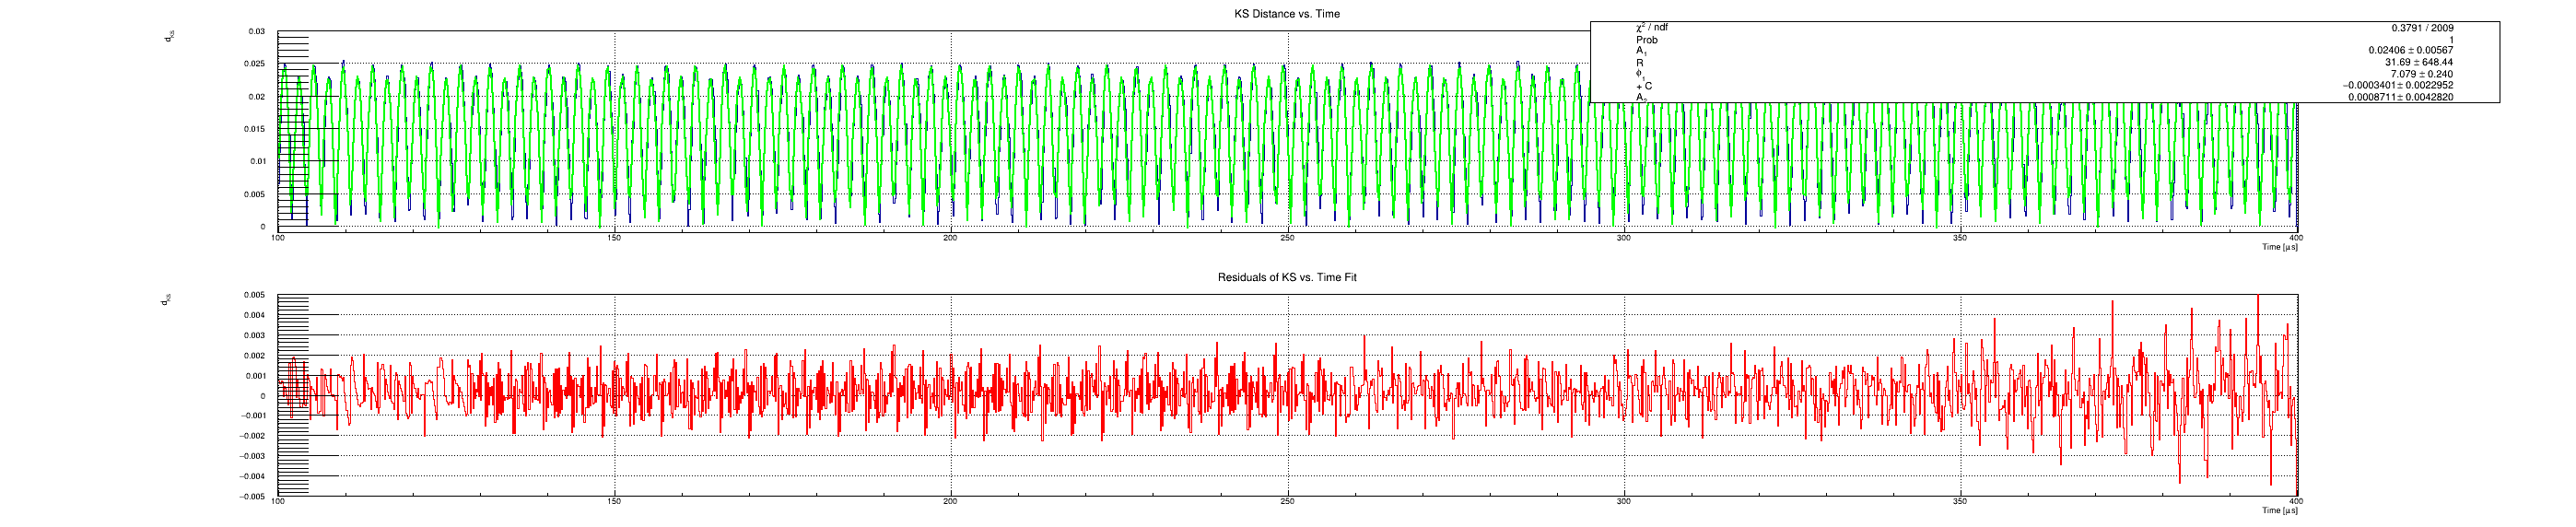

In [41]:
c = r.TCanvas("c","c",2800,600)
x1 = 100
x2 = x1+300
c.Divide(1,2)
c.cd(1)
hspec2.Draw()
hspec2.GetXaxis().SetRangeUser(x1,x2)
hspec2.GetYaxis().SetRangeUser(-0.001,0.03)
r.gPad.SetGrid()
c.cd(2)
hspec_resid2.SetLineColor(2)
hspec_resid2.Draw()
hspec_resid2.GetXaxis().SetRangeUser(x1,x2)
hspec_resid2.GetYaxis().SetRangeUser(-0.005,0.005)
r.gPad.SetGrid()
c.Draw()

---

### Now lets add in a quartic term to the magnitude of the sine

---

### Lets now fourier transform this fit function

In [42]:
ffthists = [hspec2.Clone(), hspec_resid2.Clone()]

4700 699.9999999999999 -0.07446808510638298 699.9255319148936
0.14893617021276592 0.0014285714285714288
13.42857142857143 6.714285714285715
4700 699.9999999999999 -0.07446808510638298 699.9255319148936
0.14893617021276592 0.0014285714285714288
13.42857142857143 6.714285714285715


Warning in <TFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


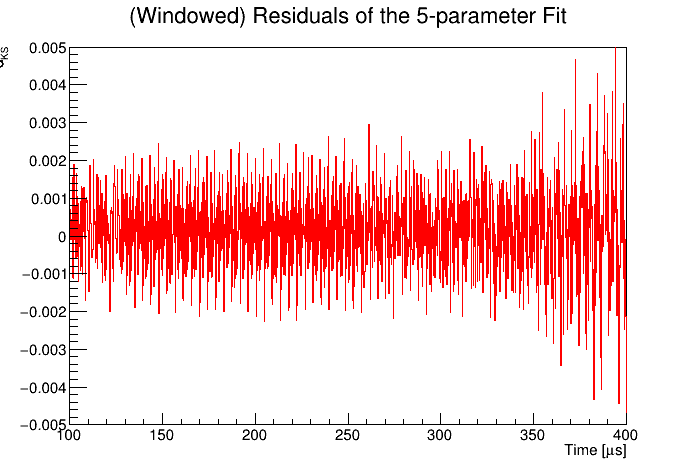

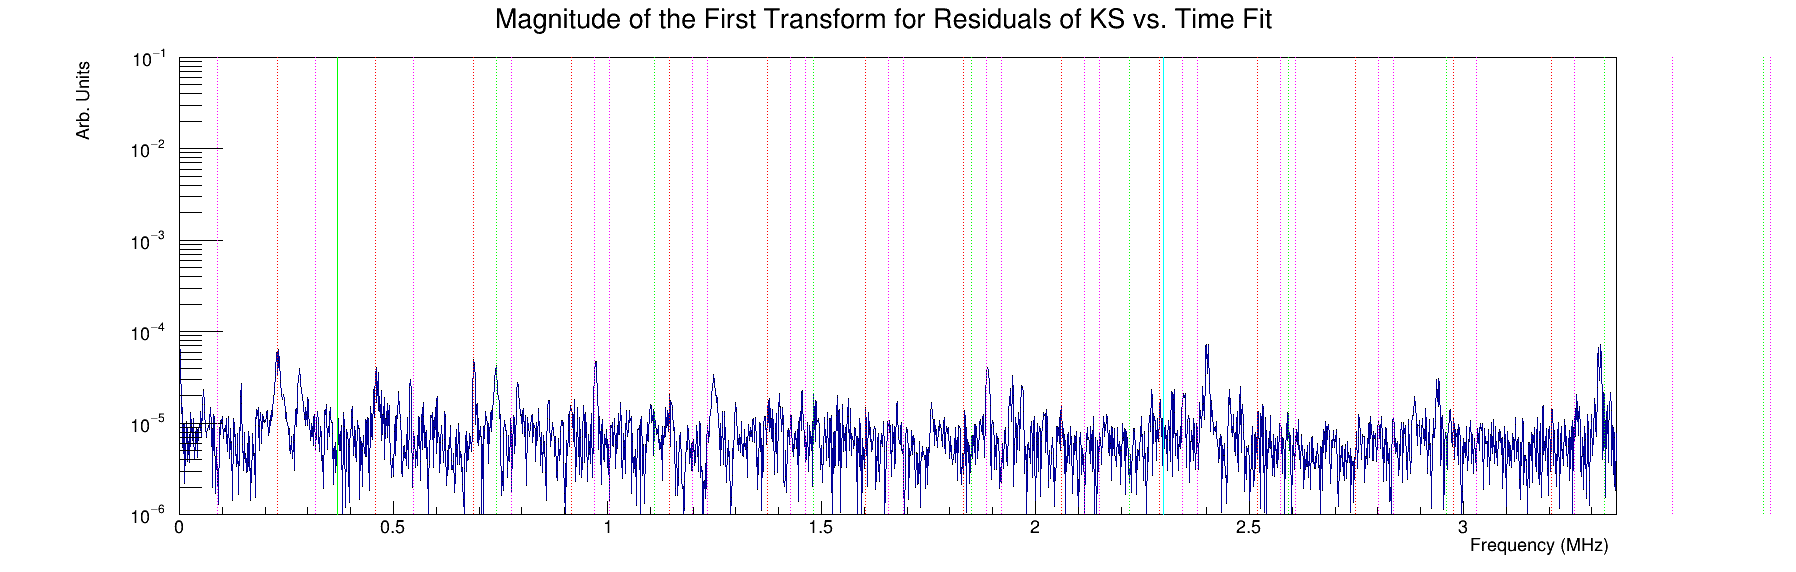

In [43]:
ffts = []

for htest in ffthists:
    c3 = r.TCanvas()
    residuals5param = htest.Clone()
    nBins = residuals5param.GetSize() - 2 #total number of bins excluding over/underflow

    #apply a windows function to try to get rid of the imaginary peaks
    welchVec = []
    for i in range(nBins):
        unwindowed = residuals5param.GetBinContent(i)
        welch = 1 #- ( ( i - (nBins - 1) / 2) / ((nBins - 1) / 2) )**2
        welchVec.append(welch)
        residuals5param.SetBinContent(i, unwindowed *  welch)

    residuals5param.Draw()
    residuals5param.GetXaxis().SetRangeUser(t1global,t2global)
    residuals5param.SetTitle("(Windowed) Residuals of the 5-parameter Fit")
    c3.Draw() 
    
    hxform = r.TH1D()
    hxform = 0
    r.TVirtualFFT.SetTransform(0)
    hxform = residuals5param.FFT(hxform,"MAG P")
    hxform.SetTitle("Magnitude of the First Transform for "+(htest.GetTitle()))
    #NOTE: for "real" frequencies you have to divide the x-axes range with the range of your function
    #    y-axes has to be rescaled by a factor of 1/SQRT(n) to be right: this is not done automatically!
    normXform = hxform.GetEntries()
    hxform.Scale(1/normXform)
    c2 = r.TCanvas("c2","c2",1800,600)
    c2.cd()
    #c2.SetLogy()
    hxform.GetXaxis().SetTitle("Frequency (MHz)")
    hxform.GetYaxis().SetTitle("Arb. Units")
    hxform.Draw("HIST P0 L")
    c2.Draw()

    Npart = residuals5param.GetSize() - 2
    minBinCenter = residuals5param.GetXaxis().GetBinCenter(0)
    maxBinCenter = residuals5param.GetXaxis().GetBinCenter(Npart)

    capT = maxBinCenter - minBinCenter
    print(Npart, capT, minBinCenter, maxBinCenter)
    deltaT = capT/Npart #microseconds
    deltaF = 1/capT
    print(deltaT, deltaF)

    deltaTns = deltaT*1000 #nanoseconds
    limmaxHz = (1/(deltaTns*math.pow(10.0,-9)))
    limmaxMHz = limmaxHz / math.pow(10.0,6)

    limmax = 2*deltaF*Npart #400-25
    print(limmax,limmaxMHz)
    #hxform.GetXaxis().SetLimits(0,limmax)
    nbins = residuals5param.GetSize() - 2
    hxform.SetBins(Npart,0,limmaxMHz)
    hxform.GetXaxis().SetRangeUser(0,limmaxMHz/2)
    #hxform.GetXaxis().SetRangeUser(0,1.4)

    residuals5paramXform = hxform.Clone()

    hxform.GetYaxis().SetRangeUser(0.000001,0.1)
    cboline = r.TLine(0.37,0.000001,0.37,0.1)
    cboline.SetLineColor(3)
    cboline.Draw("SAME")

    vwline = r.TLine(2.3,0.000001,2.3,0.1)
    vwline.SetLineColor(7)
    vwline.Draw("SAME")
    
    oalines = []
    for i in range(1,15):
        oalinei = r.TLine(0.229*i,0.000001,0.229*i,0.1)
        oalinei.SetLineColor(2)
        oalinei.SetLineStyle(3)
        oalinei.Draw()
        oalines.append(oalinei)
        
    oa_cbo_lines = []
    oa_cbo_lines_pos = []
    oa_cbo_lines_neg = []
    for i in range(1,15):
        oalinei = r.TLine(0.37*i,0.000001,0.37*i,0.1)
        oalinei.SetLineColor(3)
        oalinei.SetLineStyle(3)
        oalinei.Draw()
        oa_cbo_lines.append(oalinei)
    for i in range(1,15):
        oalinei = r.TLine(0.229*i+0.37*2,0.000001,0.229*i+0.37*2,0.1)
        oalinei.SetLineColor(6)
        oalinei.SetLineStyle(3)
        oalinei.Draw()
        oa_cbo_lines_pos.append(oalinei)
    for i in range(2,15):
        oalinei = r.TLine(0.229*i-0.37,0.000001,0.229*i-0.37,0.1)
        oalinei.SetLineColor(6)
        oalinei.SetLineStyle(3)
        oalinei.Draw()
        oa_cbo_lines_neg.append(oalinei)

    c2.SetLogy()
    c2.Draw()
    
    ffts.append(hxform.Clone())

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


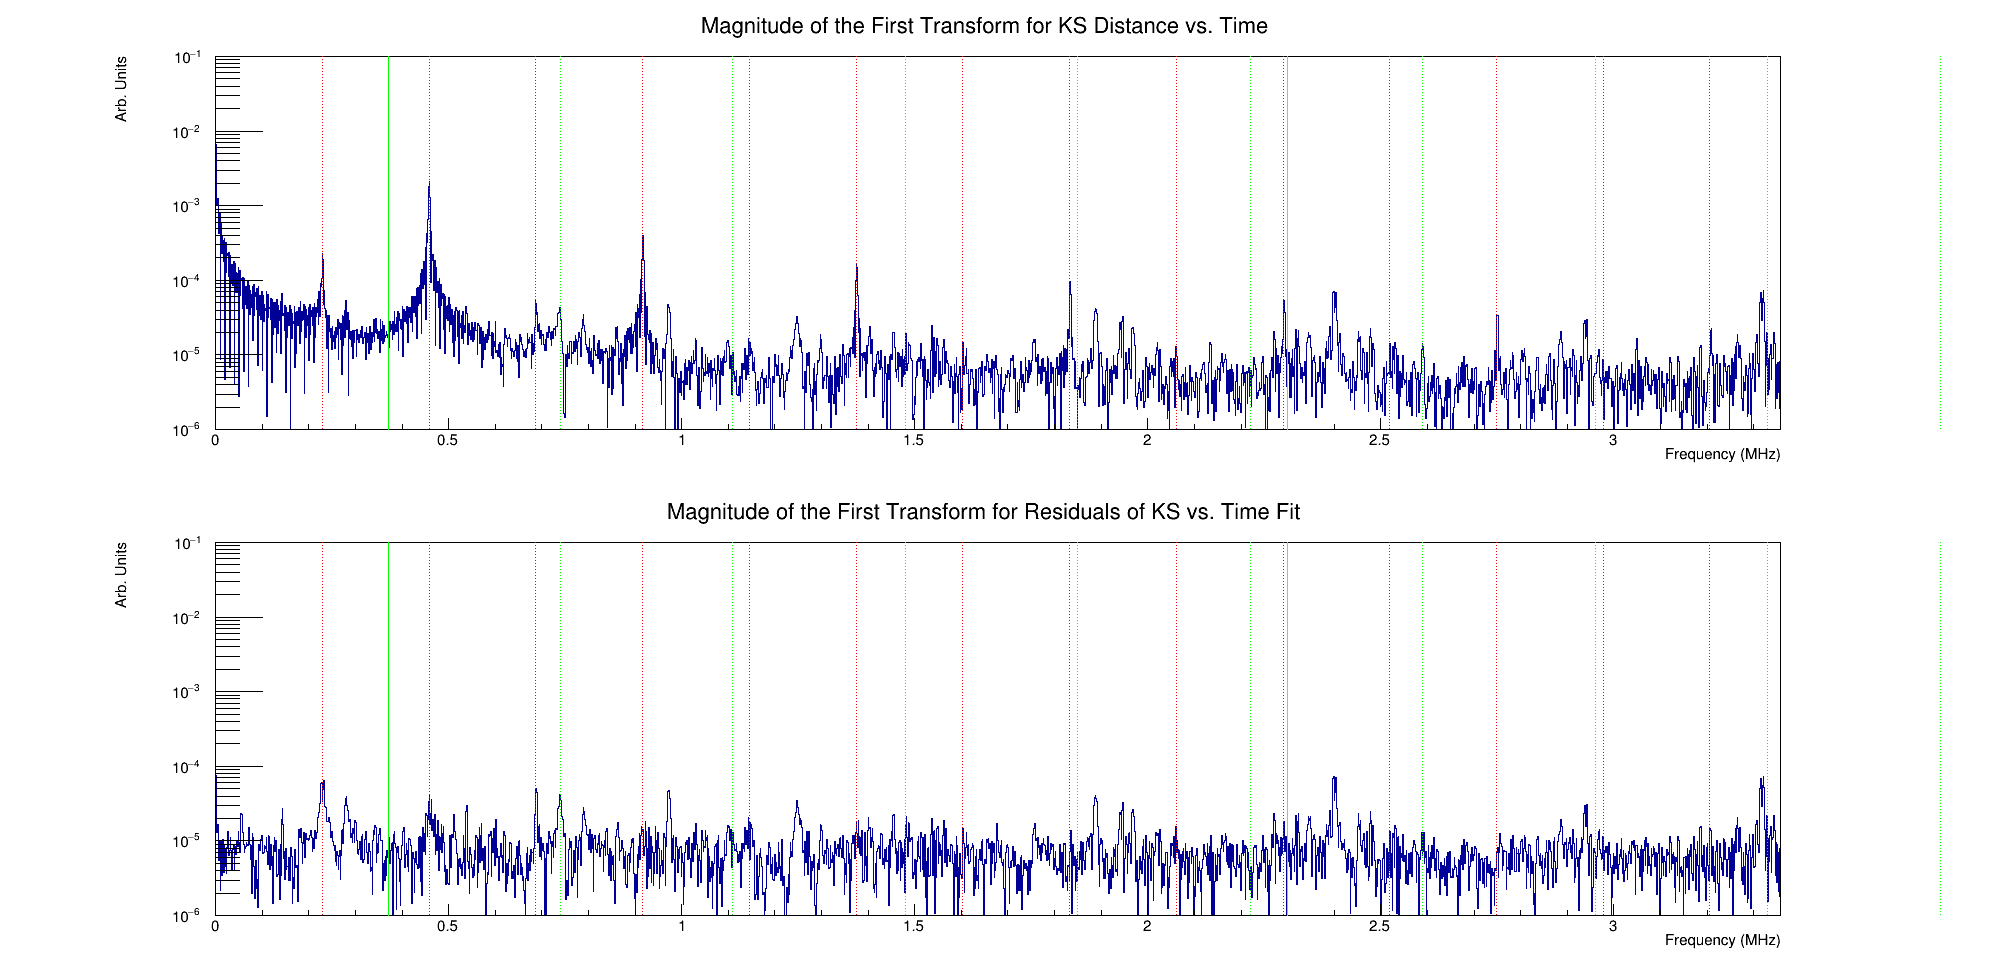

In [44]:
c = r.TCanvas("c","c",2000,1000)
c.Divide(1,2)
for i, h in enumerate(ffts):
    c.cd(i+1)
    r.gPad.SetLogy()
    h.Draw("hist")
    
    cboline.Draw("SAME")
    vwline.Draw("SAME")
    for oalinei in oalines:
        oalinei.Draw("SAME")
    for oalinei in oa_cbo_lines:
        oalinei.Draw("SAME")
    #for oalinei in oa_cbo_lines_neg:
    #    oalinei.Draw("SAME")
    
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


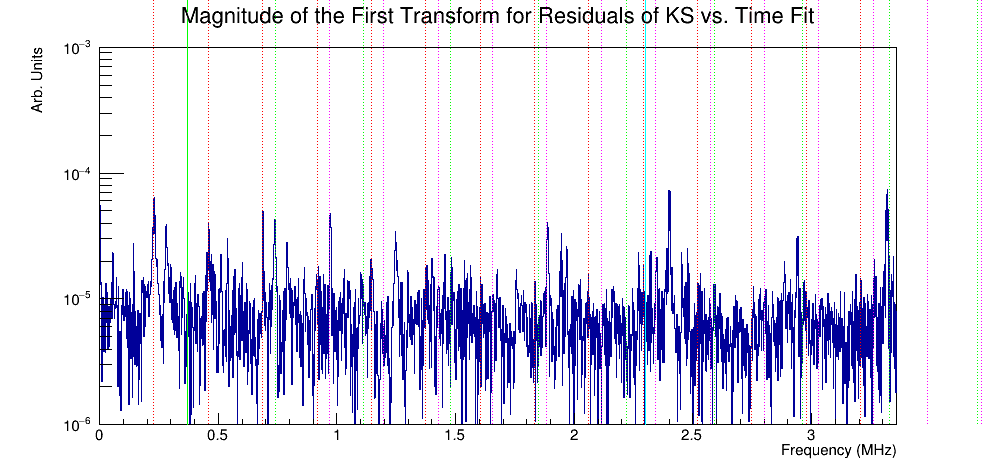

In [45]:
c = r.TCanvas("c","c",1000,500)
for i, h in enumerate(ffts):
    r.gPad.SetLogy()
    h.Draw("hist")
    h.GetYaxis().SetRangeUser(0.000001,0.001)
    
    cboline.Draw("SAME")
    vwline.Draw("SAME")
    for oalinei in oalines:
        oalinei.Draw("SAME")
    for oalinei in oa_cbo_lines:
        oalinei.Draw("SAME")
    for oalinei in oa_cbo_lines_pos:
        oalinei.Draw("SAME")
    
c.Draw()

---

### Looks like theres a lot of CBO in there still, let's see if we can take that out

In [46]:
def peak_fit_sine_4(x, p):
    R = p[1]
    omega = getBlinded.paramToFreq(R)
    return ( p[0]*r.TMath.Abs(r.TMath.Sin(omega*x[0] + p[2]))    #Abs value of normal omega_a term
            + p[3]                                               #const offset from 0
            + ( p[4] )*r.TMath.Sin(omega*x[0] + p[2])            #omega_a modulated sine
            + p[8]*r.TMath.Abs(r.TMath.Sin(p[6]*x[0] + p[7]))    #Abs value of normal cbo term
            + ( p[5] )*r.TMath.Sin(p[6]*x[0] + p[7])             #omega_cbo modulated sine
            )
            
func4 = r.TF1("modsine_cbo", peak_fit_sine_4, 100,400,9)
func4.SetParNames('A_{1}','R','#phi_{a}','+ C', 'A_{2}', 'A_{CBO - 2}', '#omega_{CBO}', '#phi_{CBO}', 'A_{CBO - 1}')
func4.SetParameters(0.03,0,0,0.002,0.002,0.000001,0.37,0,0.00001)
func4.SetParLimits(0,0.02,100)
func4.SetParLimits(7,-6.3, 6.3)
func4.SetLineColor(6)
func4.SetNpx(1000)

In [47]:
hspec4 = hspec_orig.Clone("hspec4")

0 0.024059330381995935
1 31.69465400967408
2 7.078776221408072
3 -0.0003400988058669771
4 0.0008710675306708744
5 0.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


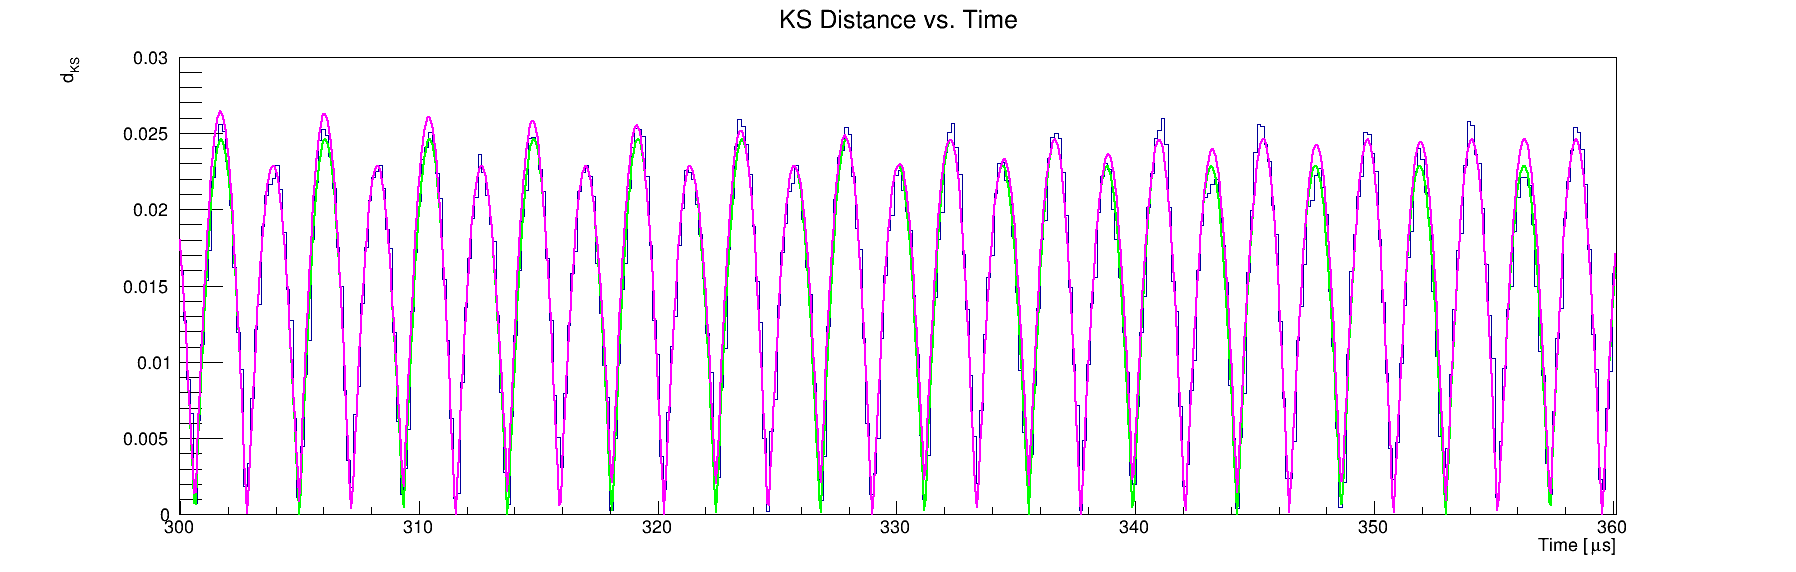

In [48]:
c = r.TCanvas("c","c",1800,600)
hspec4.Draw()
hspec4.GetYaxis().SetRangeUser(0,0.03)
hspec4.GetXaxis().SetRangeUser(300,360)
for i in range(6):
    func4.SetParameter(i, func3.GetParameter(i))  
    print(i, func3.GetParameter(i))
func4.SetParameter(5,0.001)
func4.SetParameter(6,0.37*4)
func4.SetParameter(7,3.14/2)
func4.SetParameter(8,0.001)
func3.Draw("SAME")
func4.Draw("SAME")
c.Draw()

Starting fit: 1
Starting fit: 2
 FCN=0.375133 FROM MINOS     STATUS=SUCCESSFUL    570 CALLS        9677 TOTAL
                     EDM=5.28839e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  A_{1}        2.40366e-02   5.68541e-03  -2.97329e-06   3.49351e-03
   2  R            3.21496e+01   6.49479e+02  -3.12824e-01  -6.59653e-06
   3  #phi_{a}     7.07836e+00   2.40502e-01   9.57584e-05  -1.92301e-02
   4  + C         -5.14508e-04   3.81850e-03  -3.06353e-05   1.44046e-01
   5  A_{2}        8.54514e-04   4.31621e-03  -7.15986e-08  -3.13573e-03
   6  A_{CBO - 2}   6.92355e-05   2.53425e-03   6.94197e-07   3.00028e-02
   7  #omega_{CBO}   1.47272e+00   1.14634e-02  -7.56681e-07   2.10862e-01
   8  #phi_{CBO}   1.73641e+00   2.37738e+00   6.04446e-05   5.09843e-03
   9  A_{CBO - 1}   3.00604e-04   5.21058e-03   5.21058e-03   7.63727e-02
 FCN=

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


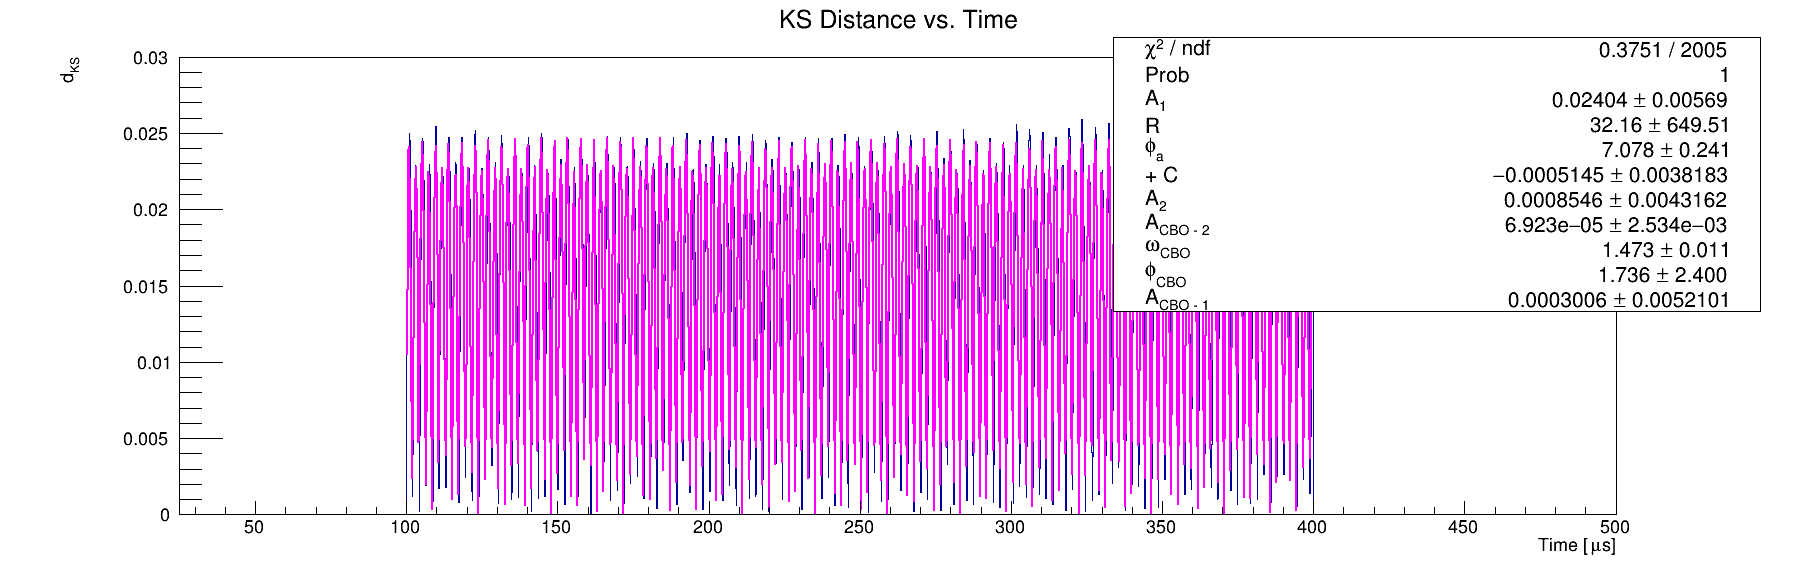

In [49]:
c = r.TCanvas("c","c",1800,600)
hspec4.Draw()
hspec4.GetXaxis().SetRangeUser(25,500)
for i in range(2):
    print("Starting fit:", i+1)
    hspec4.Fit("modsine_cbo","REMB")
c.Draw()

In [50]:
for i in range(9):
    print(func4.GetParameter(i), func4.GetParError(i))

0.024036584782805737 0.0056853857476846514
32.16072632956197 649.506101972774
7.078355452082956 0.2405131789598396
-0.0005144957725623144 0.003818294512508647
0.0008545910033725116 0.004316198449399505
6.923337642827472e-05 0.0025339308075752053
1.4727224709546065 0.011236100378823463
1.7364133817554501 2.4002543860967753
0.0003006070142941445 0.005210124783170511


Creating new Ratio Plot


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


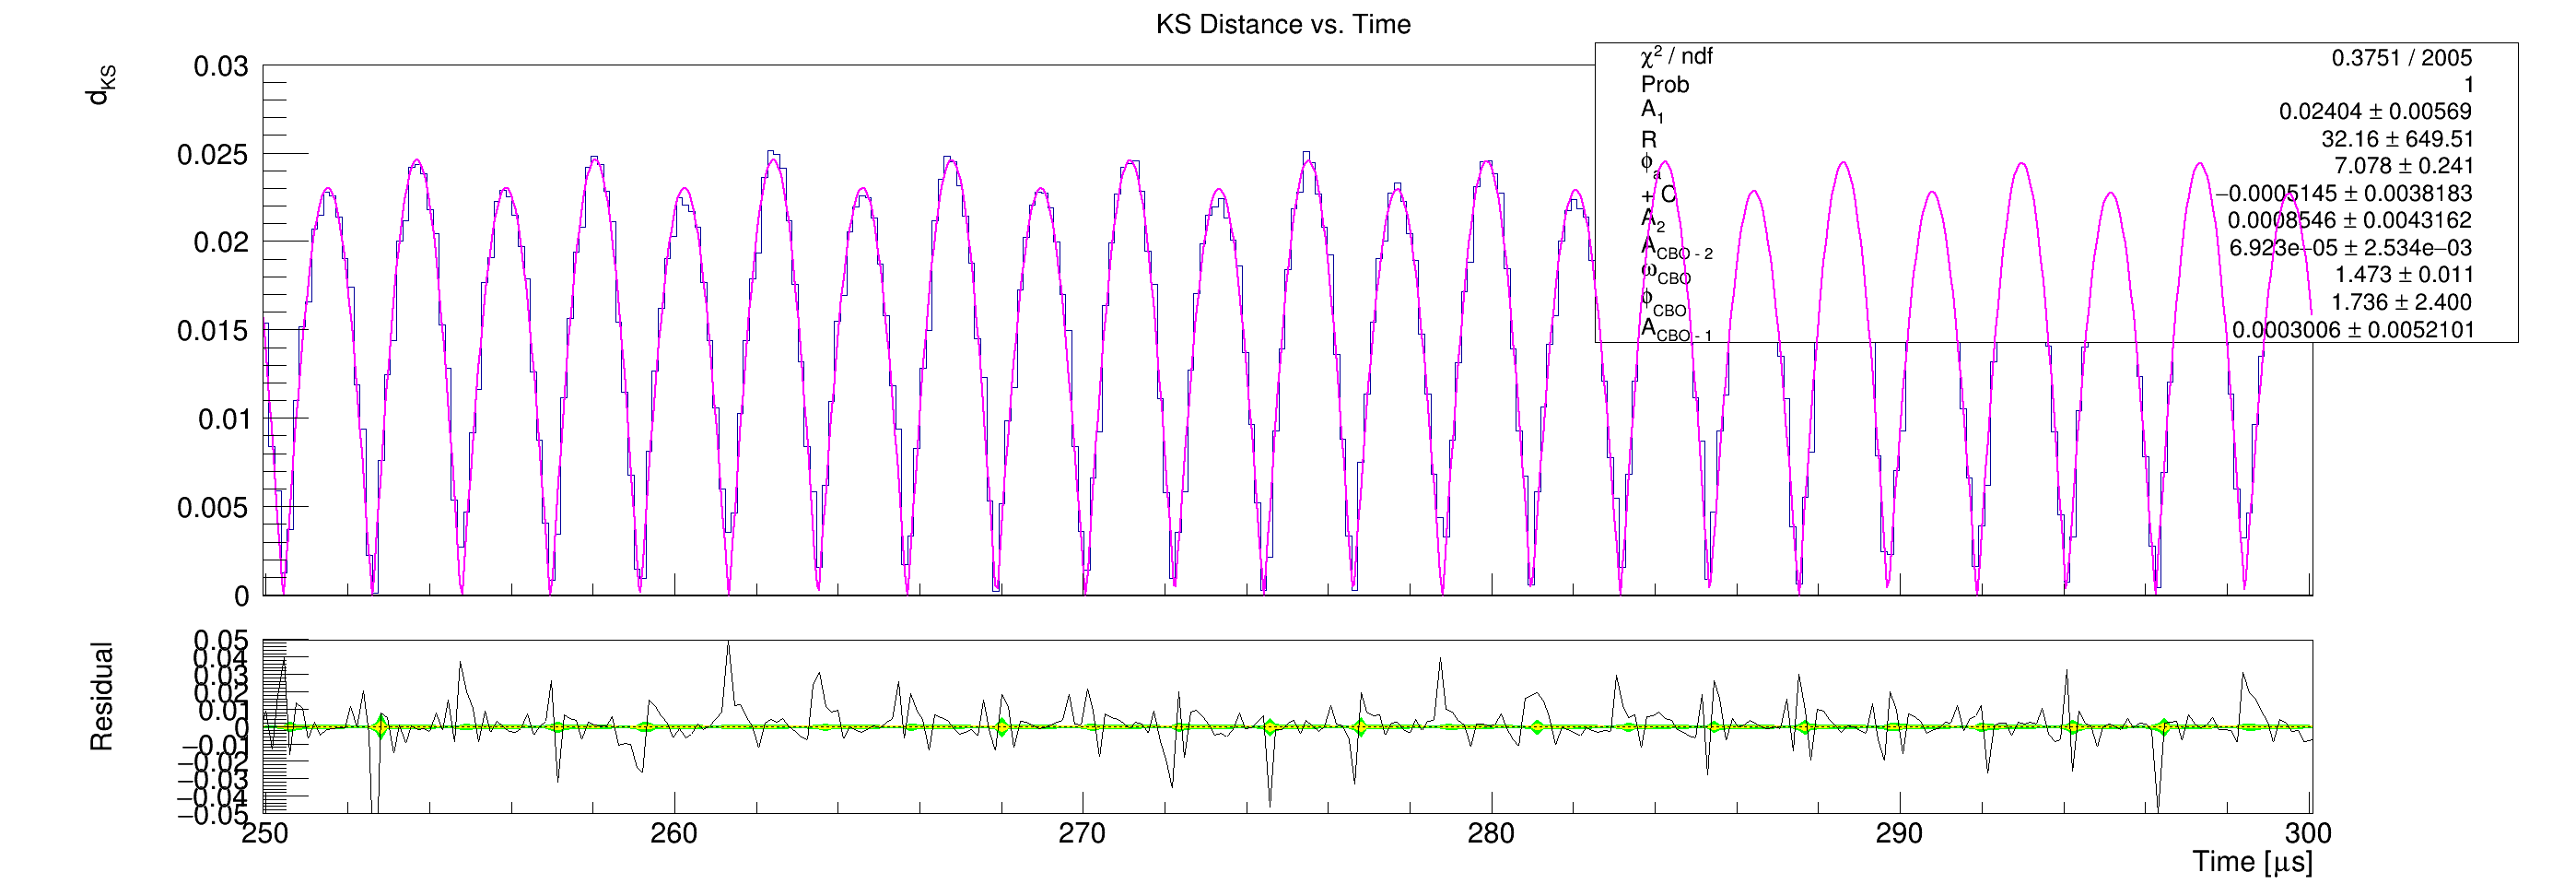

In [51]:
#The class calculates the  difference between the histogram and the fit function at each point 
#    and divides it by the uncertainty.
c3 = r.TCanvas("c","c",2800,1000)
hspec4.Draw()
hspec4.GetXaxis().SetRangeUser(250,300)

c3.Draw()

try:
    rp4.Delete()
except:
    print("Creating new Ratio Plot")

rp4 = r.TRatioPlot(hspec4)
rp4.Draw()
rp4.GetLowerRefYaxis().SetTitle("Residual")
rp4.GetLowerRefYaxis().SetRangeUser(-0.05,0.05)


c3.Update()
c3.Draw()

In [52]:
hspec_resid4 = hspec4.Clone()
hspec_resid4.Reset()
hspec_resid4.SetTitle("Residuals of KS vs. Time Fit")

residVec = []
nBins = hspec4.GetSize() - 2
for i in range(nBins):
    binCenterX = hspec4.GetXaxis().GetBinCenter(i)
    if (binCenterX > t1global and binCenterX < t2global):
        residVec.append( (binCenterX, hspec4.GetBinContent(i) - func4.Eval(binCenterX) ) )
        hspec_resid4.SetBinContent(i, hspec4.GetBinContent(i) - func4.Eval(binCenterX))
    else:
        hspec_resid4.SetBinContent(i, 0)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


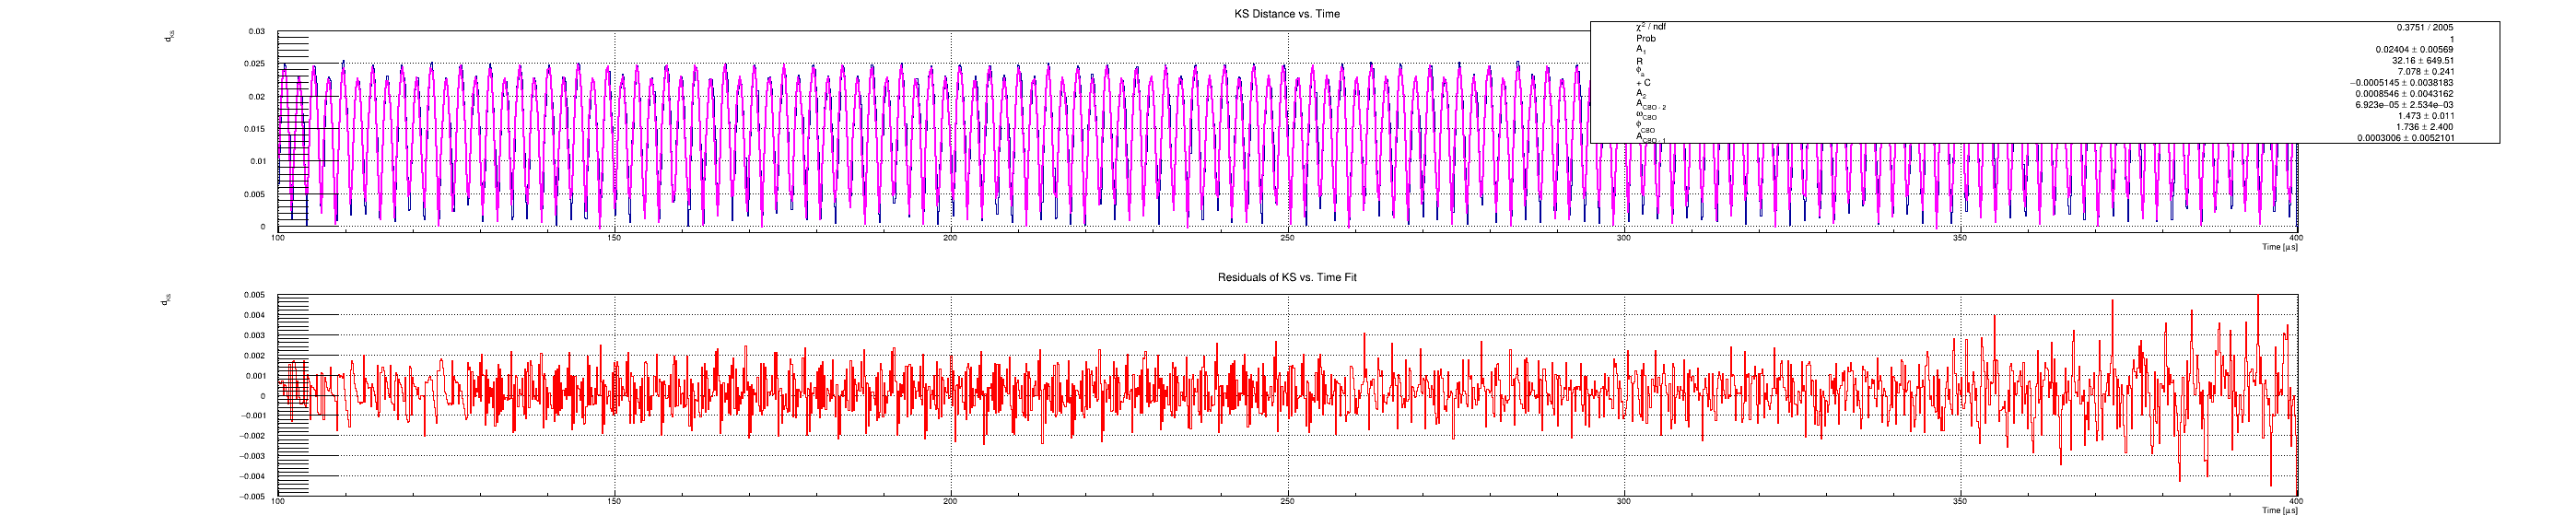

In [53]:
c = r.TCanvas("c","c",2800,600)
x1 = 100
x2 = x1+300
c.Divide(1,2)
c.cd(1)
hspec4.Draw()
hspec4.GetXaxis().SetRangeUser(x1,x2)
hspec4.GetYaxis().SetRangeUser(-0.001,0.03)
r.gPad.SetGrid()
c.cd(2)
hspec_resid4.SetLineColor(2)
hspec_resid4.Draw()
hspec_resid4.GetXaxis().SetRangeUser(x1,x2)
hspec_resid4.GetYaxis().SetRangeUser(-0.005,0.005)
r.gPad.SetGrid()
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


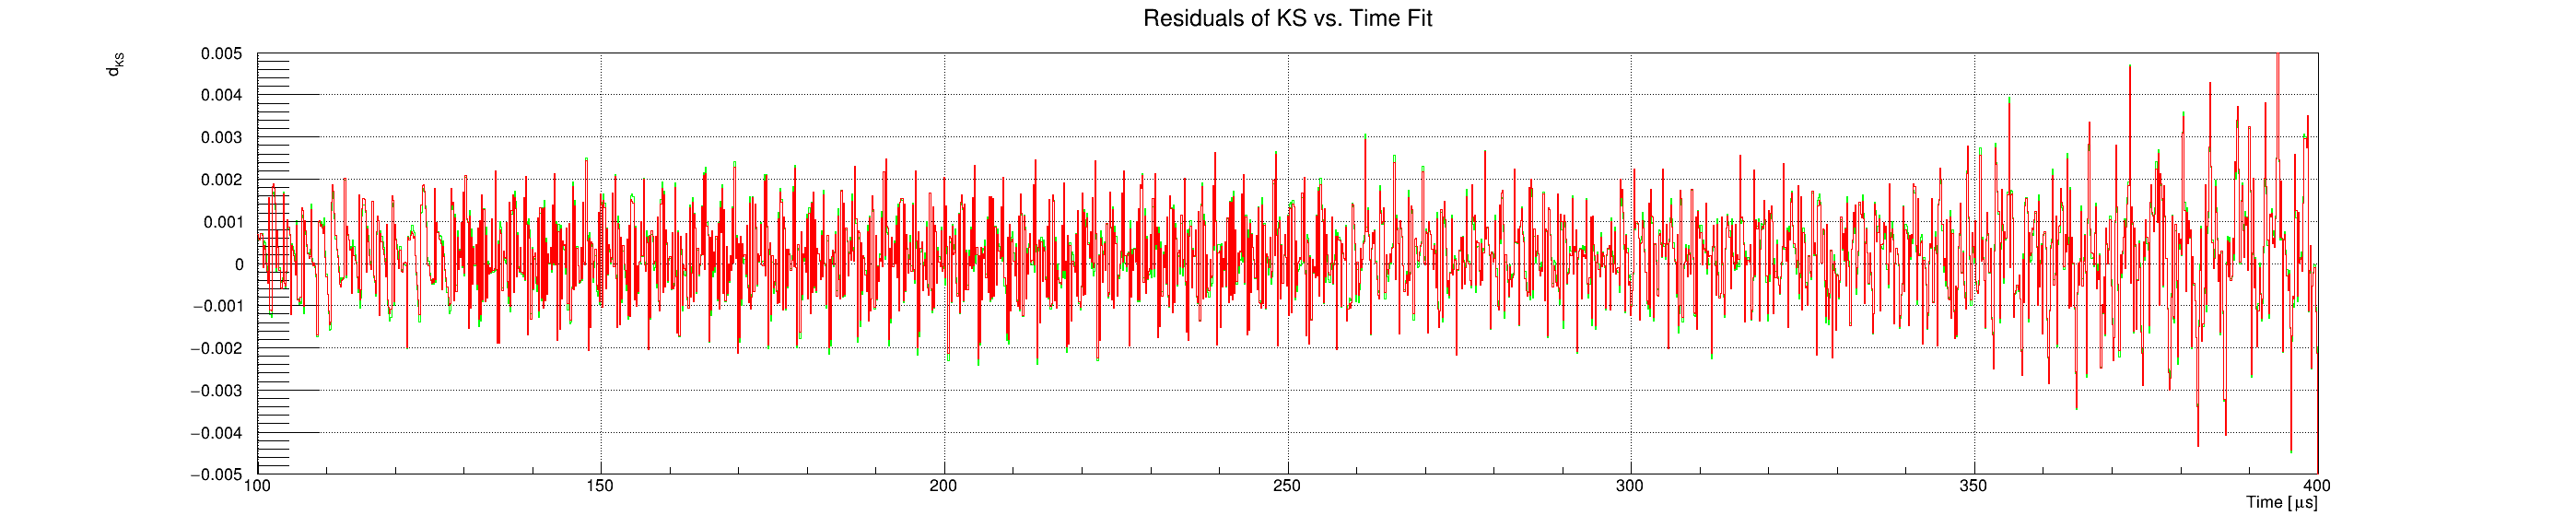

In [54]:
c = r.TCanvas("c","c",2800,600)
x1 = 100
x2 = x1+300

hspec_resid4.SetLineColor(3)
hspec_resid4.Draw()
hspec_resid4.GetXaxis().SetRangeUser(x1,x2)
hspec_resid4.GetYaxis().SetRangeUser(-0.005,0.005)

hspec_resid2.Draw("SAME")

r.gPad.SetGrid()
c.Draw()

---

### Lets now fourier transform this fit function with the CBO term and compare to the non-CBO function

In [55]:
ffthists = [hspec4.Clone(), hspec_resid4.Clone()]

4700 699.9999999999999 -0.07446808510638298 699.9255319148936
0.14893617021276592 0.0014285714285714288
13.42857142857143 6.714285714285715
4700 699.9999999999999 -0.07446808510638298 699.9255319148936
0.14893617021276592 0.0014285714285714288
13.42857142857143 6.714285714285715


Warning in <TFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2
Warning in <TFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


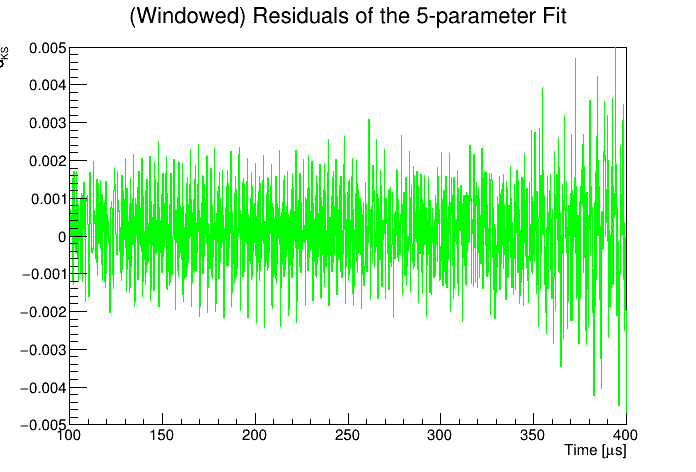

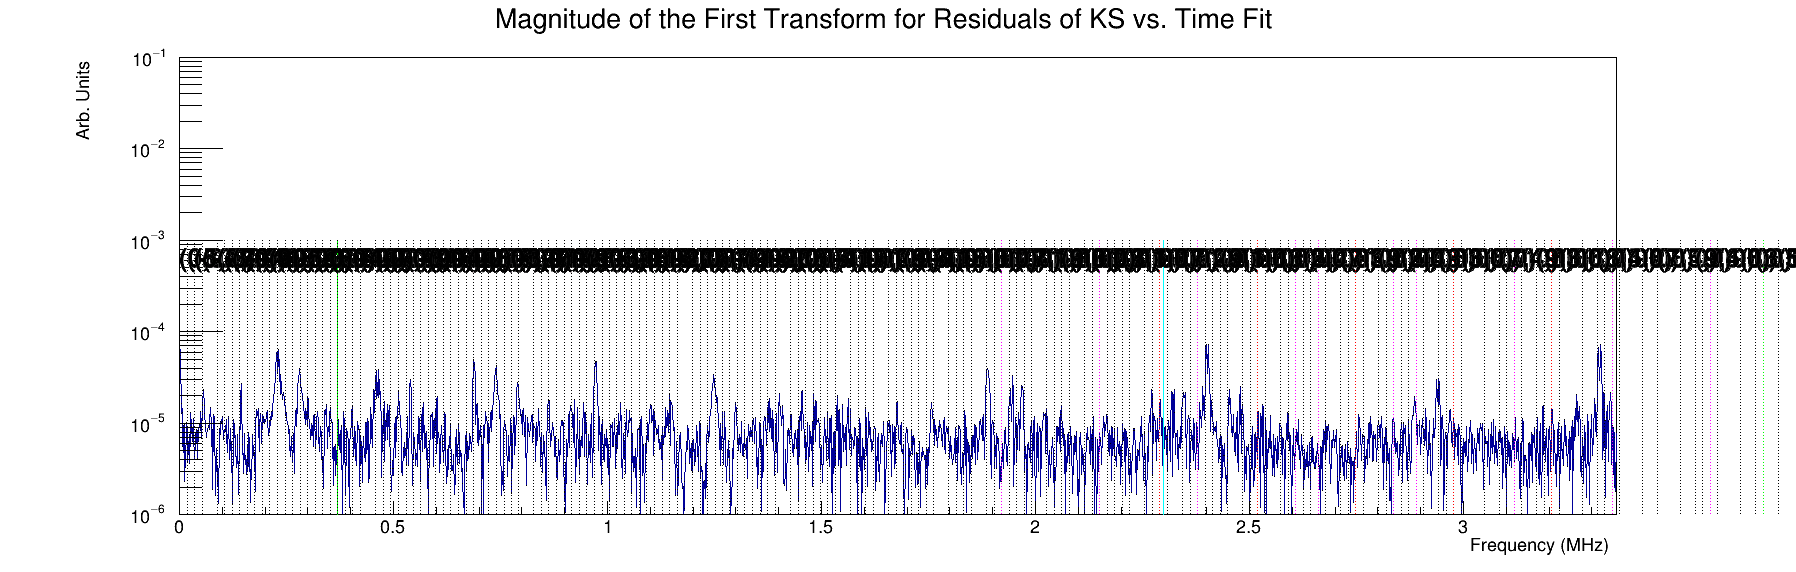

In [56]:
ffts4 = []

for htest in ffthists:
    c3 = r.TCanvas()
    residuals5param = htest.Clone()
    nBins = residuals5param.GetSize() - 2 #total number of bins excluding over/underflow

    #apply a windows function to try to get rid of the imaginary peaks
    welchVec = []
    for i in range(nBins):
        unwindowed = residuals5param.GetBinContent(i)
        welch = 1 #- ( ( i - (nBins - 1) / 2) / ((nBins - 1) / 2) )**2
        welchVec.append(welch)
        residuals5param.SetBinContent(i, unwindowed *  welch)

    residuals5param.Draw()
    residuals5param.GetXaxis().SetRangeUser(t1global,t2global)
    residuals5param.SetTitle("(Windowed) Residuals of the 5-parameter Fit")
    c3.Draw() 
    
    hxform = r.TH1D()
    hxform = 0
    r.TVirtualFFT.SetTransform(0)
    hxform = residuals5param.FFT(hxform,"MAG P")
    hxform.SetTitle("Magnitude of the First Transform for "+(htest.GetTitle()))
    #NOTE: for "real" frequencies you have to divide the x-axes range with the range of your function
    #    y-axes has to be rescaled by a factor of 1/SQRT(n) to be right: this is not done automatically!
    normXform = hxform.GetEntries()
    hxform.Scale(1/normXform)
    c2 = r.TCanvas("c2","c2",1800,600)
    c2.cd()
    #c2.SetLogy()
    hxform.GetXaxis().SetTitle("Frequency (MHz)")
    hxform.GetYaxis().SetTitle("Arb. Units")
    hxform.Draw("HIST P0 L")
    c2.Draw()

    Npart = residuals5param.GetSize() - 2
    minBinCenter = residuals5param.GetXaxis().GetBinCenter(0)
    maxBinCenter = residuals5param.GetXaxis().GetBinCenter(Npart)

    capT = maxBinCenter - minBinCenter
    print(Npart, capT, minBinCenter, maxBinCenter)
    deltaT = capT/Npart #microseconds
    deltaF = 1/capT
    print(deltaT, deltaF)

    deltaTns = deltaT*1000 #nanoseconds
    limmaxHz = (1/(deltaTns*math.pow(10.0,-9)))
    limmaxMHz = limmaxHz / math.pow(10.0,6)

    limmax = 2*deltaF*Npart #400-25
    print(limmax,limmaxMHz)
    #hxform.GetXaxis().SetLimits(0,limmax)
    nbins = residuals5param.GetSize() - 2
    hxform.SetBins(Npart,0,limmaxMHz)
    hxform.GetXaxis().SetRangeUser(0,limmaxMHz/2)
    #hxform.GetXaxis().SetRangeUser(0,1.4)

    residuals5paramXform = hxform.Clone()

    hxform.GetYaxis().SetRangeUser(0.000001,0.1)
    
    cboline = r.TLine(0.37,0.000001,0.37,0.001)
    cboline.SetLineColor(3)
    cboline.Draw("SAME")

    vwline = r.TLine(2.3,0.000001,2.3,0.001)
    vwline.SetLineColor(7)
    vwline.Draw("SAME")
    
    oalines = []
    for i in range(1,15):
        oalinei = r.TLine(0.229*i,0.000001,0.229*i,0.001)
        oalinei.SetLineColor(2)
        oalinei.SetLineStyle(3)
        oalinei.Draw()
        oalines.append(oalinei)
        
    oa_cbo_lines = []
    oa_cbo_lines_pos = []
    oa_cbo_lines_pos_2 = []
    oa_cbo_lines_neg = []
    oa_cbo_lines_allCombos = []
    ttvec = []
    for i in range(1,15):
        oalinei = r.TLine(0.37*i,0.000001,0.37*i,0.001)
        oalinei.SetLineColor(3)
        oalinei.SetLineStyle(3)
        oalinei.Draw()
        oa_cbo_lines.append(oalinei)
    for i in range(1,15):
        oalinei = r.TLine(0.229*i+0.37,0.000001,0.229*i+0.37,0.001)
        oalinei.SetLineColor(6)
        oalinei.SetLineStyle(3)
        oalinei.Draw()
        oa_cbo_lines_pos.append(oalinei)
    for i in range(1,15):
        oalinei = r.TLine(0.229+0.37*i,0.000001,0.229+0.37*i,0.001)
        oalinei.SetLineColor(12)
        oalinei.SetLineStyle(3)
        oalinei.Draw()
        oa_cbo_lines_pos_2.append(oalinei)
    for i in range(2,15):
        oalinei = r.TLine(0.229*i-0.37,0.000001,0.229*i-0.37,0.001)
        oalinei.SetLineColor(6)
        oalinei.SetLineStyle(3)
        oalinei.Draw()
        oa_cbo_lines_neg.append(oalinei)
    for i in range(-10,10):
        for j in range(-10,10):
            for k in range(0,1):
                if(0.229*i+0.37*j+2.3*k < 0):
                    continue
                oalinei = r.TLine(0.229*i+0.37*j+2.3*k,0.000001,0.229*i+0.37*j+2.3*k,0.001)
                oalinei.SetLineColor(1)
                oalinei.SetLineStyle(3)
                oalinei.Draw()
                oa_cbo_lines_allCombos.append(oalinei)

                tt = r.TText(.229*i+0.37*j+2.3*k,0.0005,"("+str(i)+","+str(j)+","+str(k)+")")
                ttvec.append(tt)
                tt.Draw()

    c2.SetLogy()
    c2.Draw()
    
    ffts4.append(hxform.Clone())

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


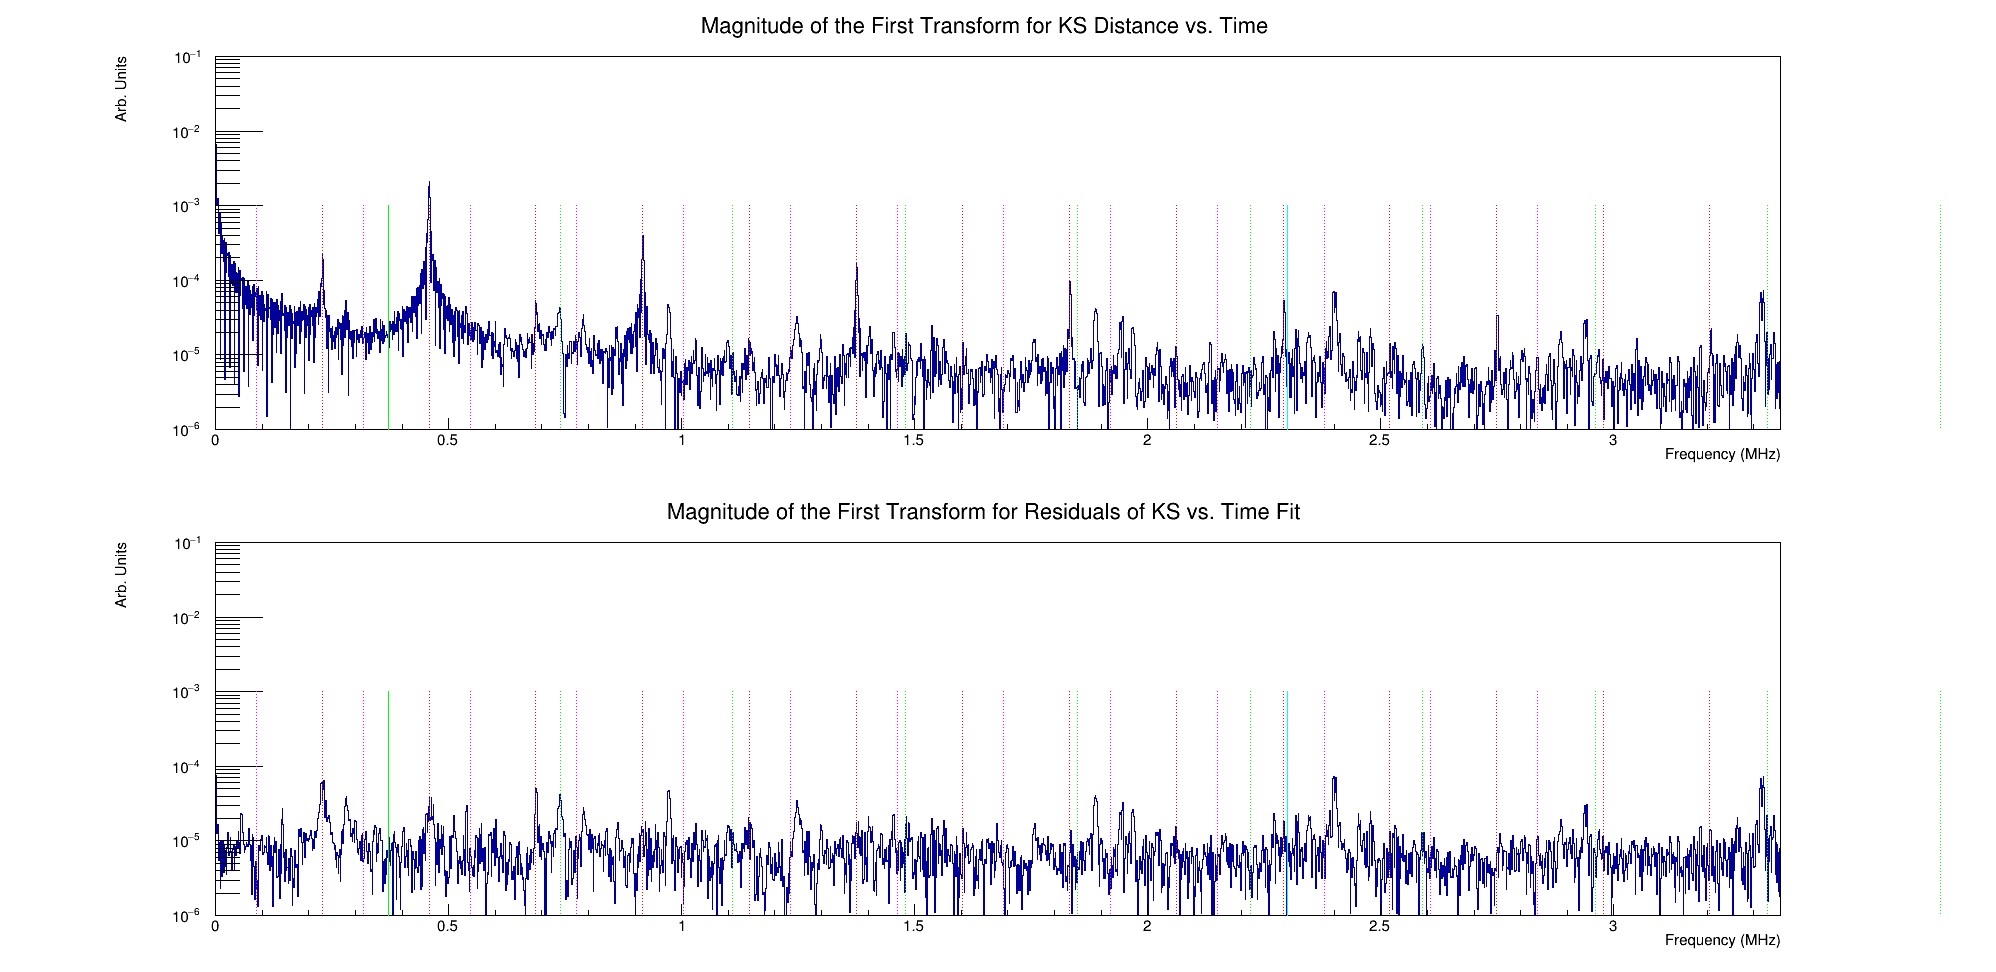

In [57]:
c = r.TCanvas("c","c",2000,1000)
c.Divide(1,2)
for i, h in enumerate(ffts4):
    c.cd(i+1)
    r.gPad.SetLogy()
    h.Draw("hist")
    
    cboline.Draw("SAME")
    vwline.Draw("SAME")
    for oalinei in oalines:
        oalinei.Draw("SAME")
    for oalinei in oa_cbo_lines:
        oalinei.Draw("SAME")
    for oalinei in oa_cbo_lines_neg:
        oalinei.Draw("SAME")
    
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


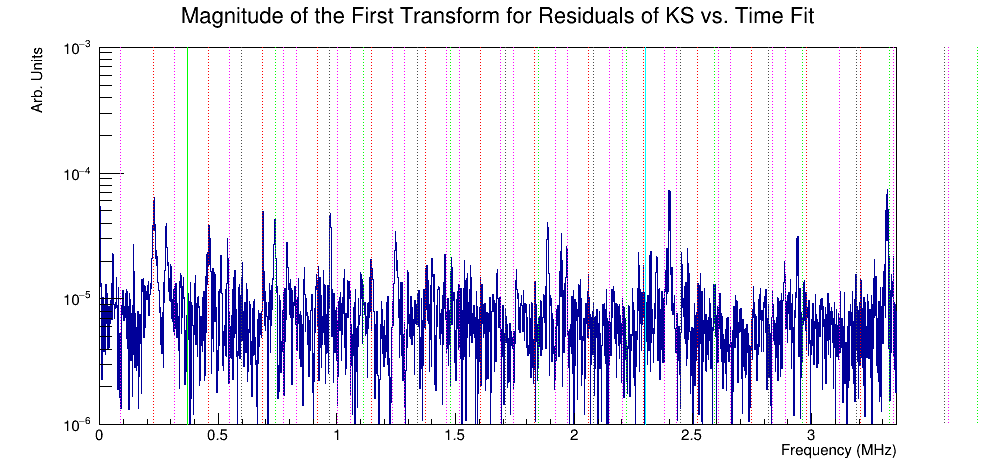

In [58]:
c = r.TCanvas("c","c",1000,500)

r.gPad.SetLogy()
#ffts[1].Draw("hist")
#ffts4[1].SetLineColor(1)
ffts4[1].Draw("hist same")
h.GetYaxis().SetRangeUser(0.000001,0.001)

cboline.Draw("SAME")
vwline.Draw("SAME")
for oalinei in oalines:
    oalinei.Draw("SAME")
for oalinei in oa_cbo_lines:
    oalinei.Draw("SAME")
for oalinei in oa_cbo_lines_pos:
    oalinei.Draw("SAME")
for oalinei in oa_cbo_lines_neg:
    oalinei.Draw("SAME")
for oalinei in oa_cbo_lines_pos_2:
    oalinei.Draw("SAME")
    
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


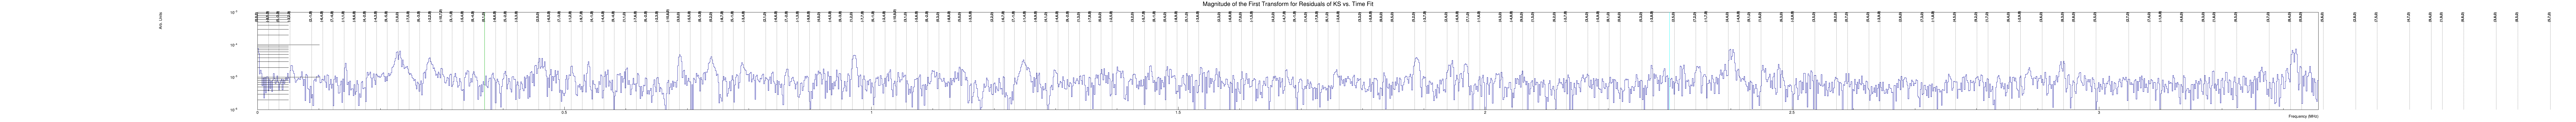

In [59]:
c = r.TCanvas("c","c",10000,500)

r.gPad.SetLogy()
#ffts[1].Draw("hist")
#ffts4[1].SetLineColor(1)
ffts4[1].Draw("hist same")
h.GetYaxis().SetRangeUser(0.000001,0.001)

cboline.Draw("SAME")
vwline.Draw("SAME")
for oalinei in oa_cbo_lines_allCombos:
    oalinei.Draw("SAME")
    
for tt in ttvec:
    tt.SetTextSize(0.03)
    tt.SetTextAngle(90)
    tt.Draw("SAME")
    
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


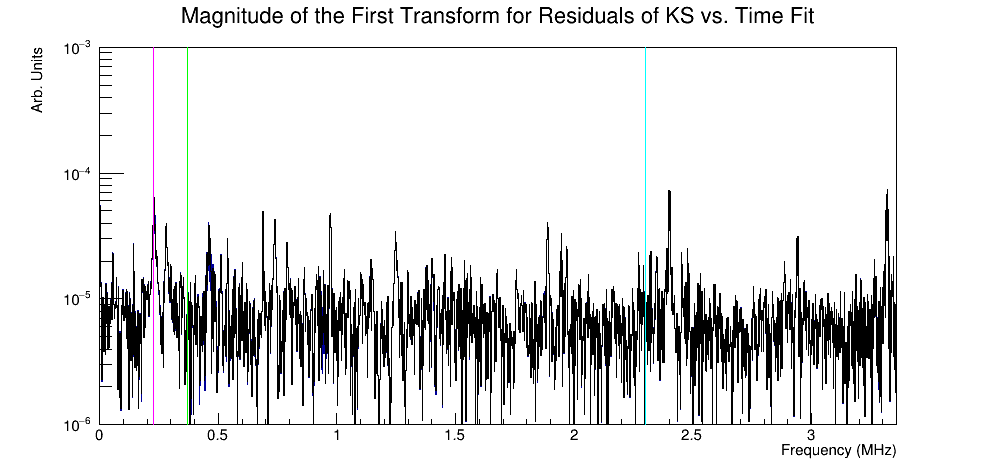

In [60]:
c = r.TCanvas("c","c",1000,500)

r.gPad.SetLogy()
ffts[1].Draw("hist")
ffts4[1].SetLineColor(1)
ffts4[1].Draw("hist same")
h.GetYaxis().SetRangeUser(0.000001,0.001)

cboline.Draw("SAME")
vwline.Draw("SAME")

ocbo = 0.37
oa = 0.229
ovw = 2.3

xfreq = ( ocbo*0
         + oa*1
         + ovw*0
        )

xline = r.TLine(xfreq,0.000001,xfreq,0.001)
xline.SetLineColor(6)
xline.Draw("SAME")

c.Draw()